In [32]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [33]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [34]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [35]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [36]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=16.txt", 'r')
Lines= file.readlines()
c_d16=[]
count = 0
for line in Lines:
    c_d16.append(line)
    count += 1
print (count)
count=0


file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=32.txt", 'r')
Lines= file.readlines()
c_d32=[]
count = 0
for line in Lines:
    c_d32.append(line)
    count += 1
print (count)
count=0



20
20
20
20
20


In [37]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames_d16=[]
filenames_d32=[]
filenames_d2_0703=[]
filenames_d4_0703=[]
filenames_d8_0703=[]
filenames_d2_rerun=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/2024-01-16 UMD__d=2/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)


# paf_data_d2_0703="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB 01+10 d=2/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d2_0703):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d2_0703.append(filenames[i])
#             break
# print (filenames_d2_0703)

# paf_data_d2_rerun="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/2024-01-16 UMD__d=4/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d2_rerun):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d2_rerun.append(filenames[i])
#             break
# print (filenames_d2_rerun)


paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/2024-01-16 UMD__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)



# paf_data_d4_0703="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/2024-01-16 UMD__d=16/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d4_0703):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d4_0703.append(filenames[i])
#             break
# print (filenames_d4_0703)

paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/2024-01-16 UMD__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)

# paf_data_d8_0703="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB__d=8/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d8_0703):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d8_0703.append(filenames[i])
#             break
# print (filenames_d8_0703)

paf_data_d16="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/2024-01-16 UMD__d=16/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d16 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d16.append(filenames[i])
            break
print (filenames_d16)

paf_data_d32="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/2024-01-16 UMD__d=32/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d32 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d32.append(filenames[i])
            break
print (filenames_d32)

['2024-01-16-152930_Line_001.txt', '2024-01-16-152954_Line_002.txt', '2024-01-16-153017_Line_003.txt', '2024-01-16-153040_Line_004.txt', '2024-01-16-153104_Line_005.txt', '2024-01-16-153224_Line_006.txt', '2024-01-16-153248_Line_007.txt', '2024-01-16-153311_Line_008.txt', '2024-01-16-153334_Line_009.txt', '2024-01-16-153358_Line_010.txt', '2024-01-16-202543_Line_011.txt', '2024-01-16-202607_Line_012.txt', '2024-01-16-202631_Line_013.txt', '2024-01-16-202654_Line_014.txt', '2024-01-16-202717_Line_015.txt', '2024-01-16-203022_Line_016.txt', '2024-01-16-203045_Line_017.txt', '2024-01-16-203108_Line_018.txt', '2024-01-16-203131_Line_019.txt', '2024-01-16-203155_Line_020.txt']
['2024-01-16-153650_Line_001.txt', '2024-01-16-153717_Line_002.txt', '2024-01-16-153745_Line_003.txt', '2024-01-16-153812_Line_004.txt', '2024-01-16-153838_Line_005.txt', '2024-01-16-154046_Line_006.txt', '2024-01-16-154113_Line_007.txt', '2024-01-16-154140_Line_008.txt', '2024-01-16-154207_Line_009.txt', '2024-01-16-

In [38]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

a_0703=Quantum_State(5)
a_rerun=Quantum_State(5)

# spam1=SPAM_Operator(5)
# spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM1/SPAM1.csv")

# spam2=SPAM_Operator(5)
# spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM2/SPAM2.csv")


2024-01-16-152930_Line_001.txt
counts: [4, 39, 34, 1625, 2, 1, 34, 101, 4, 36, 5, 103, 0, 2, 3, 7]
counts_ibm_mapping_dic: {'0000': 4, '1000': 39, '0100': 34, '1100': 1625, '0010': 2, '1010': 1, '0110': 34, '1110': 101, '0001': 4, '1001': 36, '0101': 5, '1101': 103, '0011': 0, '1011': 2, '0111': 3, '1111': 7}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



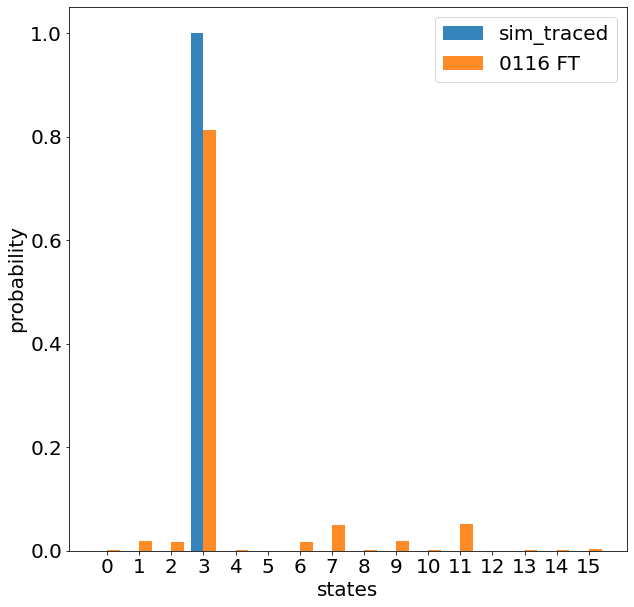

2024-01-16-152954_Line_002.txt
counts: [179, 22, 0, 10, 1659, 32, 12, 3, 5, 0, 3, 3, 51, 3, 13, 5]
counts_ibm_mapping_dic: {'0000': 179, '1000': 22, '0100': 0, '1100': 10, '0010': 1659, '1010': 32, '0110': 12, '1110': 3, '0001': 5, '1001': 0, '0101': 3, '1101': 3, '0011': 51, '1011': 3, '0111': 13, '1111': 5}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



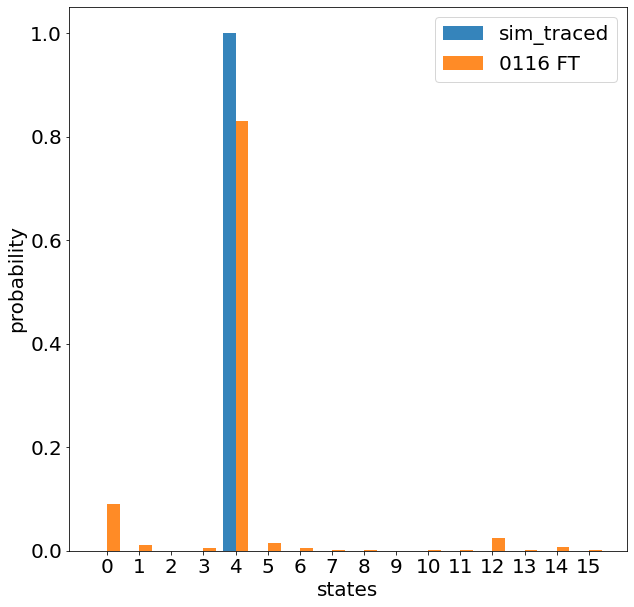

2024-01-16-153017_Line_003.txt
counts: [247, 17, 5, 3, 1518, 33, 22, 44, 19, 3, 6, 0, 60, 1, 14, 8]
counts_ibm_mapping_dic: {'0000': 247, '1000': 17, '0100': 5, '1100': 3, '0010': 1518, '1010': 33, '0110': 22, '1110': 44, '0001': 19, '1001': 3, '0101': 6, '1101': 0, '0011': 60, '1011': 1, '0111': 14, '1111': 8}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



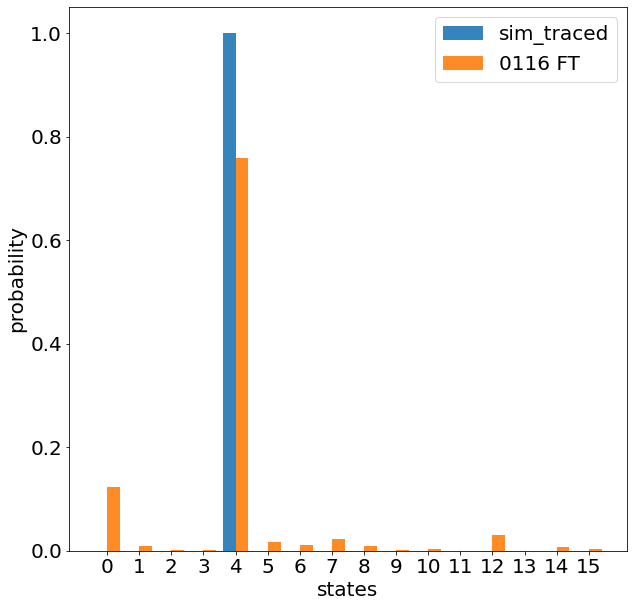

2024-01-16-153040_Line_004.txt
counts: [2, 66, 2, 30, 4, 2, 4, 3, 30, 1677, 3, 35, 36, 101, 2, 3]
counts_ibm_mapping_dic: {'0000': 2, '1000': 66, '0100': 2, '1100': 30, '0010': 4, '1010': 2, '0110': 4, '1110': 3, '0001': 30, '1001': 1677, '0101': 3, '1101': 35, '0011': 36, '1011': 101, '0111': 2, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



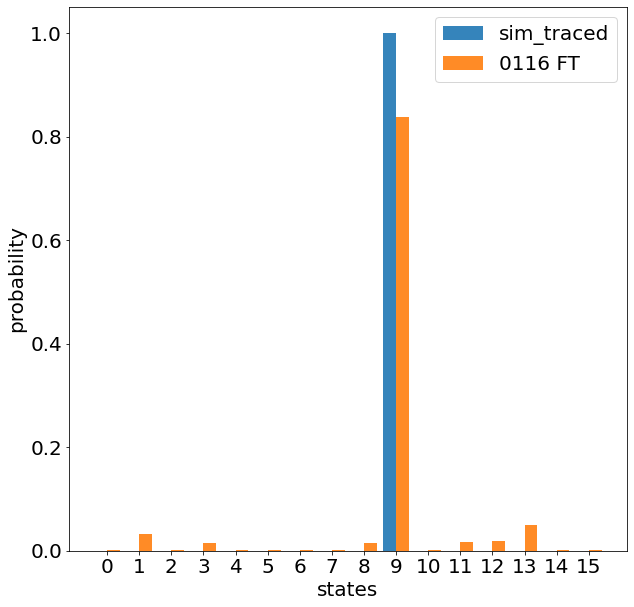

2024-01-16-153104_Line_005.txt
counts: [6, 51, 8, 119, 4, 2, 5, 5, 12, 35, 49, 1577, 13, 2, 37, 75]
counts_ibm_mapping_dic: {'0000': 6, '1000': 51, '0100': 8, '1100': 119, '0010': 4, '1010': 2, '0110': 5, '1110': 5, '0001': 12, '1001': 35, '0101': 49, '1101': 1577, '0011': 13, '1011': 2, '0111': 37, '1111': 75}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



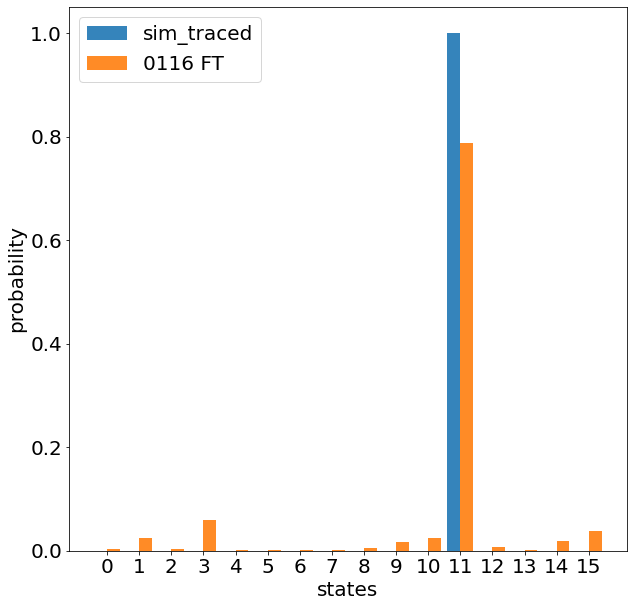

2024-01-16-153224_Line_006.txt
counts: [42, 61, 9, 2, 39, 1702, 8, 43, 4, 4, 3, 1, 4, 52, 6, 20]
counts_ibm_mapping_dic: {'0000': 42, '1000': 61, '0100': 9, '1100': 2, '0010': 39, '1010': 1702, '0110': 8, '1110': 43, '0001': 4, '1001': 4, '0101': 3, '1101': 1, '0011': 4, '1011': 52, '0111': 6, '1111': 20}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



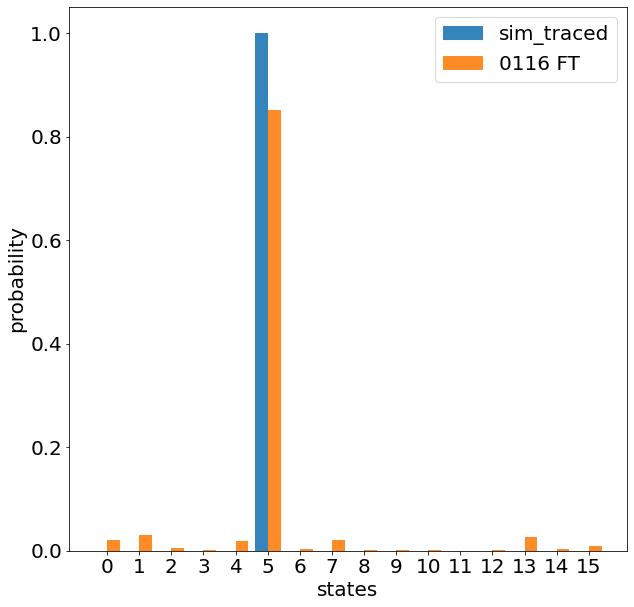

2024-01-16-153248_Line_007.txt
counts: [14, 5, 5, 20, 13, 31, 9, 110, 6, 8, 30, 120, 6, 45, 48, 1530]
counts_ibm_mapping_dic: {'0000': 14, '1000': 5, '0100': 5, '1100': 20, '0010': 13, '1010': 31, '0110': 9, '1110': 110, '0001': 6, '1001': 8, '0101': 30, '1101': 120, '0011': 6, '1011': 45, '0111': 48, '1111': 1530}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



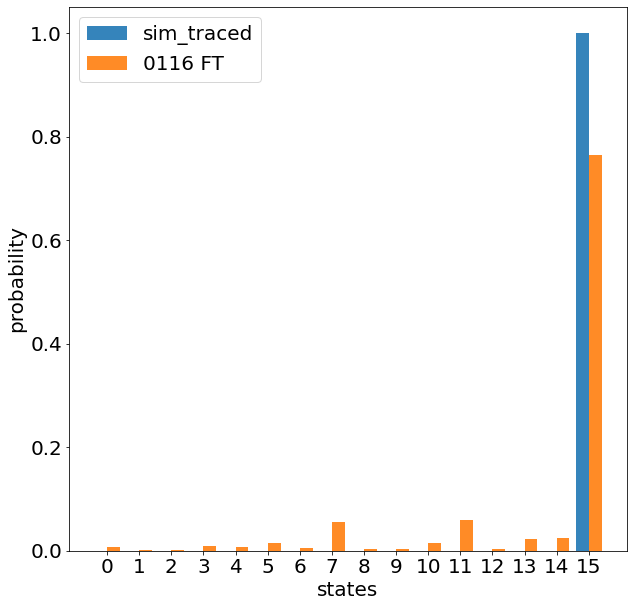

2024-01-16-153311_Line_008.txt
counts: [74, 3, 18, 5, 37, 3, 6, 4, 1562, 27, 21, 8, 200, 18, 6, 8]
counts_ibm_mapping_dic: {'0000': 74, '1000': 3, '0100': 18, '1100': 5, '0010': 37, '1010': 3, '0110': 6, '1110': 4, '0001': 1562, '1001': 27, '0101': 21, '1101': 8, '0011': 200, '1011': 18, '0111': 6, '1111': 8}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RX+21:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



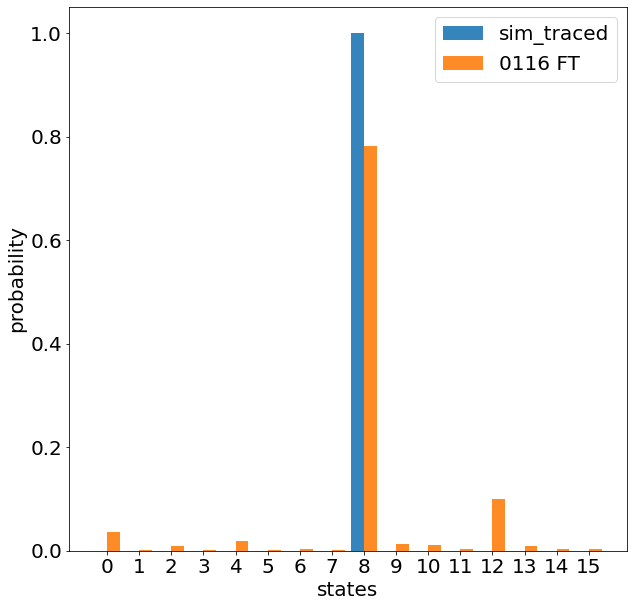

2024-01-16-153334_Line_009.txt
counts: [86, 3, 26, 6, 27, 0, 2, 3, 1541, 15, 21, 38, 192, 26, 4, 10]
counts_ibm_mapping_dic: {'0000': 86, '1000': 3, '0100': 26, '1100': 6, '0010': 27, '1010': 0, '0110': 2, '1110': 3, '0001': 1541, '1001': 15, '0101': 21, '1101': 38, '0011': 192, '1011': 26, '0111': 4, '1111': 10}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



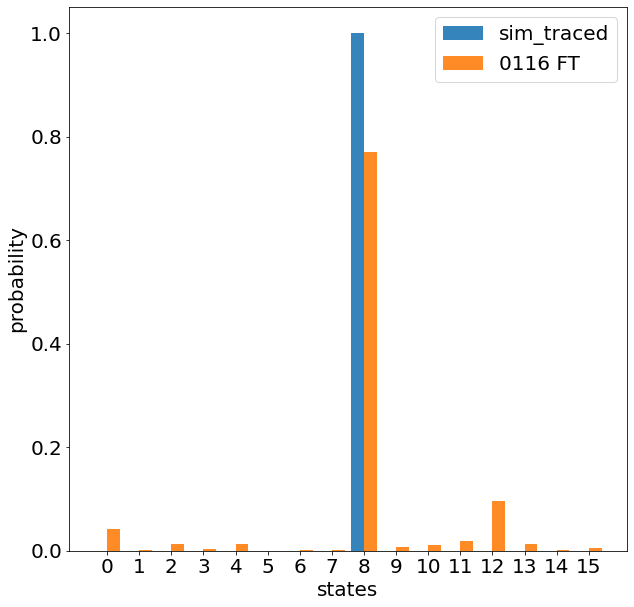

2024-01-16-153358_Line_010.txt
counts: [19, 2, 4, 18, 60, 2, 26, 7, 115, 21, 8, 7, 1628, 35, 37, 11]
counts_ibm_mapping_dic: {'0000': 19, '1000': 2, '0100': 4, '1100': 18, '0010': 60, '1010': 2, '0110': 26, '1110': 7, '0001': 115, '1001': 21, '0101': 8, '1101': 7, '0011': 1628, '1011': 35, '0111': 37, '1111': 11}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



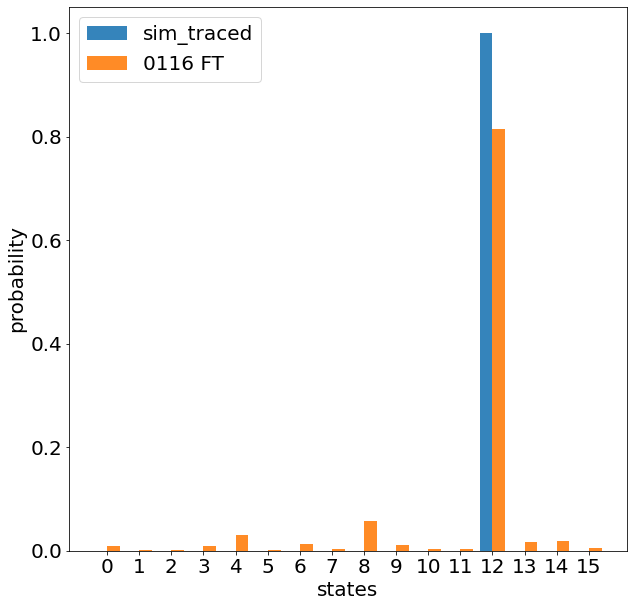

2024-01-16-202543_Line_011.txt
counts: [36, 1654, 7, 22, 27, 89, 3, 3, 5, 104, 12, 21, 2, 9, 3, 3]
counts_ibm_mapping_dic: {'0000': 36, '1000': 1654, '0100': 7, '1100': 22, '0010': 27, '1010': 89, '0110': 3, '1110': 3, '0001': 5, '1001': 104, '0101': 12, '1101': 21, '0011': 2, '1011': 9, '0111': 3, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



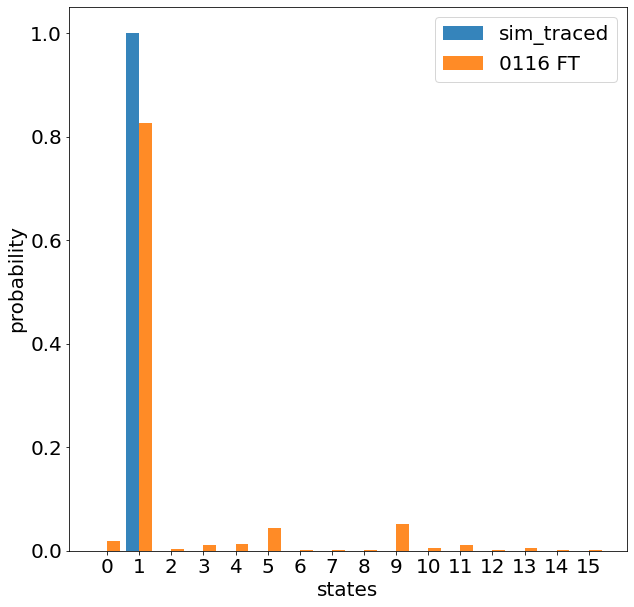

2024-01-16-202607_Line_012.txt
counts: [1, 0, 21, 3, 20, 1, 114, 3, 7, 19, 141, 22, 60, 3, 1537, 48]
counts_ibm_mapping_dic: {'0000': 1, '1000': 0, '0100': 21, '1100': 3, '0010': 20, '1010': 1, '0110': 114, '1110': 3, '0001': 7, '1001': 19, '0101': 141, '1101': 22, '0011': 60, '1011': 3, '0111': 1537, '1111': 48}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



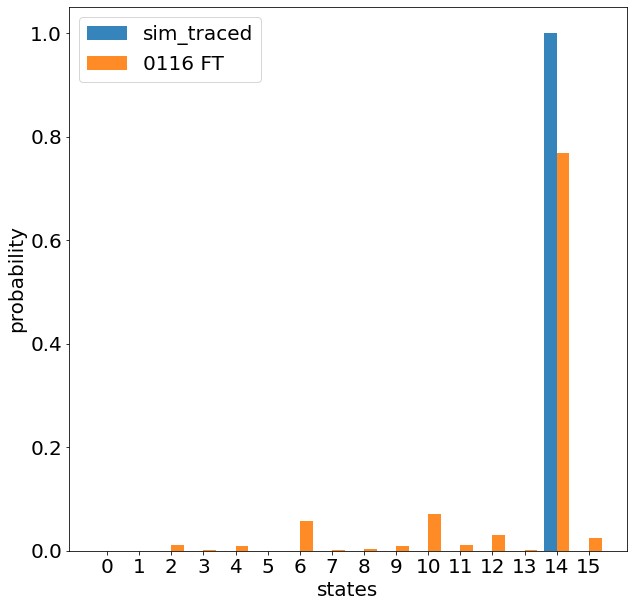

2024-01-16-202631_Line_013.txt
counts: [10, 2, 2, 10, 50, 0, 26, 6, 139, 28, 4, 6, 1656, 28, 20, 13]
counts_ibm_mapping_dic: {'0000': 10, '1000': 2, '0100': 2, '1100': 10, '0010': 50, '1010': 0, '0110': 26, '1110': 6, '0001': 139, '1001': 28, '0101': 4, '1101': 6, '0011': 1656, '1011': 28, '0111': 20, '1111': 13}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



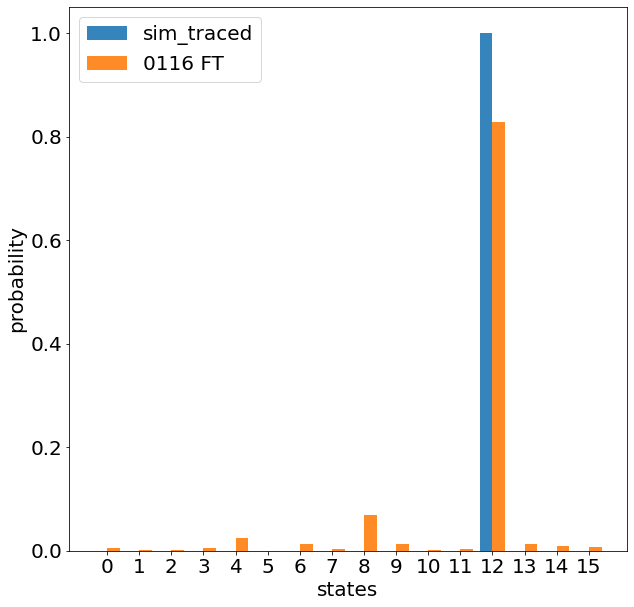

2024-01-16-202654_Line_014.txt
counts: [4, 32, 19, 1628, 19, 3, 26, 95, 17, 48, 5, 94, 2, 3, 2, 3]
counts_ibm_mapping_dic: {'0000': 4, '1000': 32, '0100': 19, '1100': 1628, '0010': 19, '1010': 3, '0110': 26, '1110': 95, '0001': 17, '1001': 48, '0101': 5, '1101': 94, '0011': 2, '1011': 3, '0111': 2, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



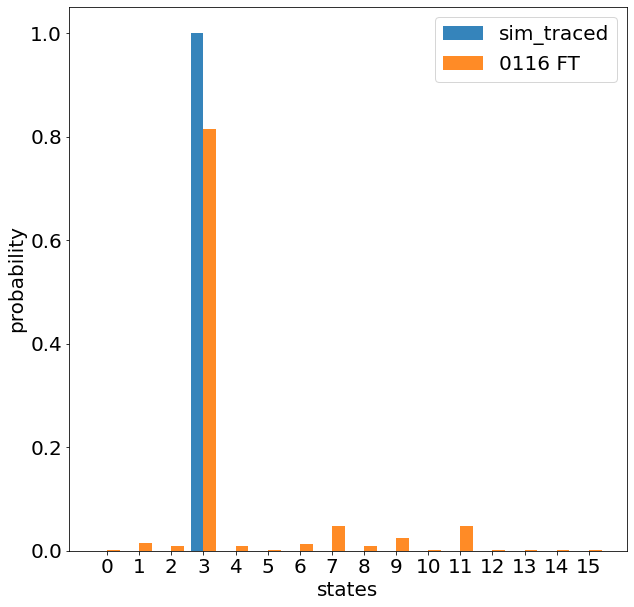

2024-01-16-202717_Line_015.txt
counts: [50, 1, 17, 4, 2, 1, 5, 1, 1662, 18, 32, 4, 159, 28, 5, 11]
counts_ibm_mapping_dic: {'0000': 50, '1000': 1, '0100': 17, '1100': 4, '0010': 2, '1010': 1, '0110': 5, '1110': 1, '0001': 1662, '1001': 18, '0101': 32, '1101': 4, '0011': 159, '1011': 28, '0111': 5, '1111': 11}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



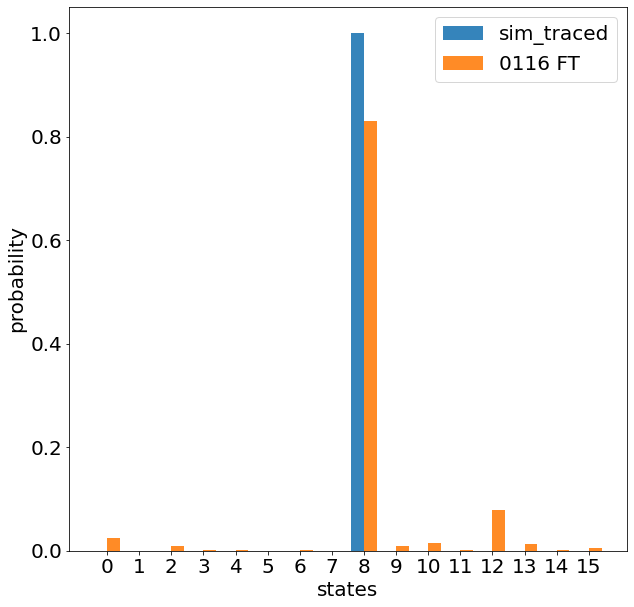

2024-01-16-203022_Line_016.txt
counts: [7, 36, 15, 1633, 19, 3, 20, 52, 3, 31, 6, 149, 0, 5, 3, 18]
counts_ibm_mapping_dic: {'0000': 7, '1000': 36, '0100': 15, '1100': 1633, '0010': 19, '1010': 3, '0110': 20, '1110': 52, '0001': 3, '1001': 31, '0101': 6, '1101': 149, '0011': 0, '1011': 5, '0111': 3, '1111': 18}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



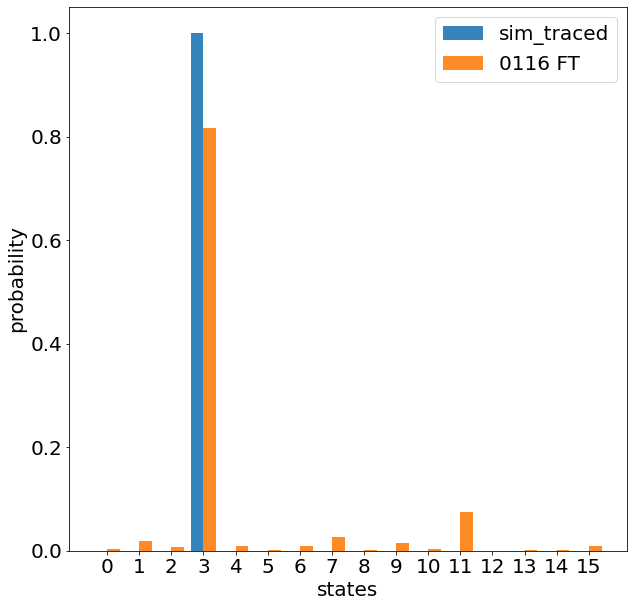

2024-01-16-203045_Line_017.txt
counts: [63, 3, 18, 14, 12, 2, 8, 1, 1536, 20, 19, 3, 255, 36, 3, 7]
counts_ibm_mapping_dic: {'0000': 63, '1000': 3, '0100': 18, '1100': 14, '0010': 12, '1010': 2, '0110': 8, '1110': 1, '0001': 1536, '1001': 20, '0101': 19, '1101': 3, '0011': 255, '1011': 36, '0111': 3, '1111': 7}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



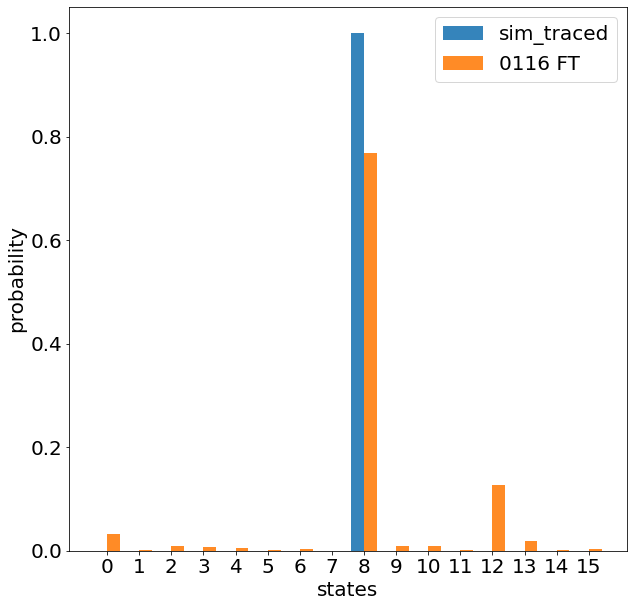

2024-01-16-203108_Line_018.txt
counts: [154, 23, 4, 2, 1678, 25, 18, 7, 13, 2, 6, 1, 37, 2, 22, 6]
counts_ibm_mapping_dic: {'0000': 154, '1000': 23, '0100': 4, '1100': 2, '0010': 1678, '1010': 25, '0110': 18, '1110': 7, '0001': 13, '1001': 2, '0101': 6, '1101': 1, '0011': 37, '1011': 2, '0111': 22, '1111': 6}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



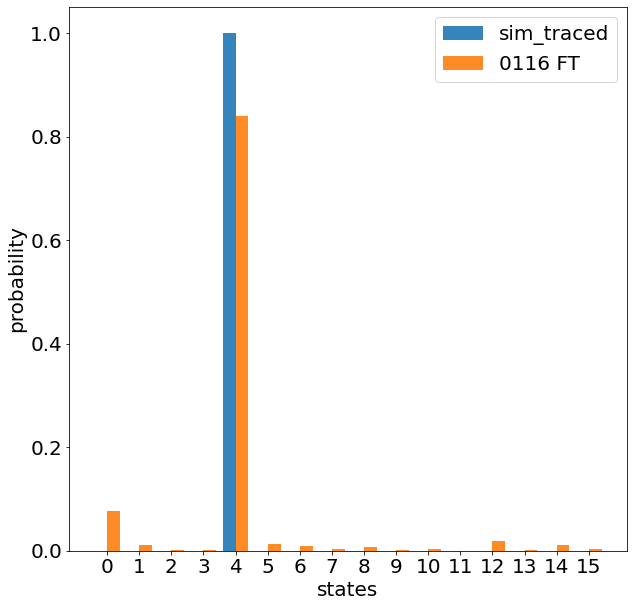

2024-01-16-203131_Line_019.txt
counts: [49, 1757, 3, 29, 27, 50, 11, 2, 1, 46, 4, 10, 0, 2, 8, 1]
counts_ibm_mapping_dic: {'0000': 49, '1000': 1757, '0100': 3, '1100': 29, '0010': 27, '1010': 50, '0110': 11, '1110': 2, '0001': 1, '1001': 46, '0101': 4, '1101': 10, '0011': 0, '1011': 2, '0111': 8, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



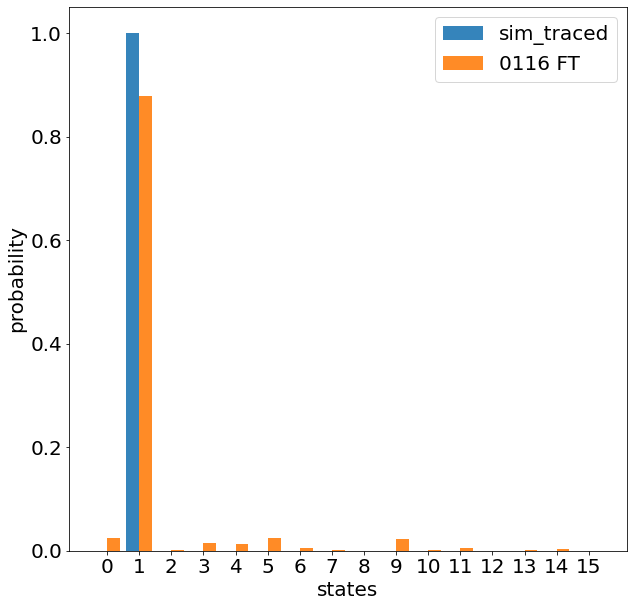

2024-01-16-203155_Line_020.txt
counts: [8, 3, 5, 5, 64, 1, 19, 10, 145, 18, 5, 4, 1647, 28, 27, 11]
counts_ibm_mapping_dic: {'0000': 8, '1000': 3, '0100': 5, '1100': 5, '0010': 64, '1010': 1, '0110': 19, '1110': 10, '0001': 145, '1001': 18, '0101': 5, '1101': 4, '0011': 1647, '1011': 28, '0111': 27, '1111': 11}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



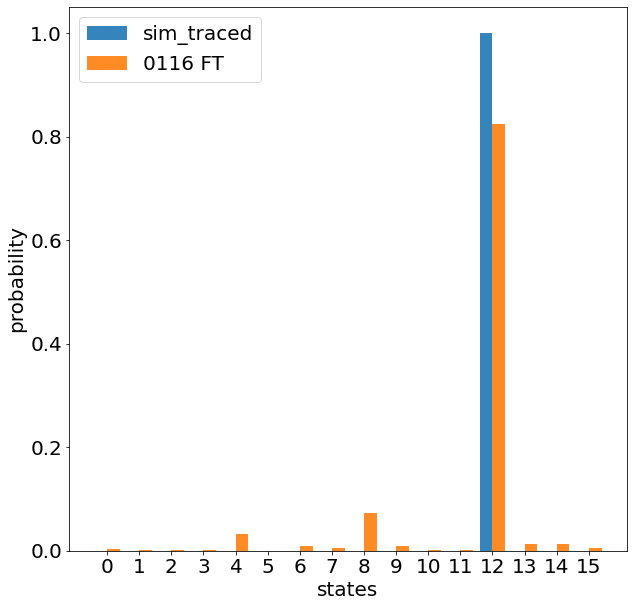

In [39]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
counts_d2_sim=[]
shots=2000
counts=[]
counts_spam=[]
counts_sim=[]
filenames_data=filenames_d2.copy()
# print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     a_s=a
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)

#     a_0703.Import(paf_data_d2_0703+filenames_d2_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    counts_sim=[round(shots*x) for x in sim_traced.population]
    counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
    counts_d2_sim.append(counts_ibm_mapping_dic_sim)
    
    
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=2","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0116 FT"])
# #       


['2024-01-16-153650_Line_001.txt', '2024-01-16-153717_Line_002.txt', '2024-01-16-153745_Line_003.txt', '2024-01-16-153812_Line_004.txt', '2024-01-16-153838_Line_005.txt', '2024-01-16-154046_Line_006.txt', '2024-01-16-154113_Line_007.txt', '2024-01-16-154140_Line_008.txt', '2024-01-16-154207_Line_009.txt', '2024-01-16-154235_Line_010.txt', '2024-01-16-201708_Line_011.txt', '2024-01-16-201735_Line_012.txt', '2024-01-16-201803_Line_013.txt', '2024-01-16-201830_Line_014.txt', '2024-01-16-201857_Line_015.txt', '2024-01-16-202021_Line_016.txt', '2024-01-16-202049_Line_017.txt', '2024-01-16-202117_Line_018.txt', '2024-01-16-202143_Line_019.txt', '2024-01-16-202210_Line_020.txt']
2024-01-16-153650_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ

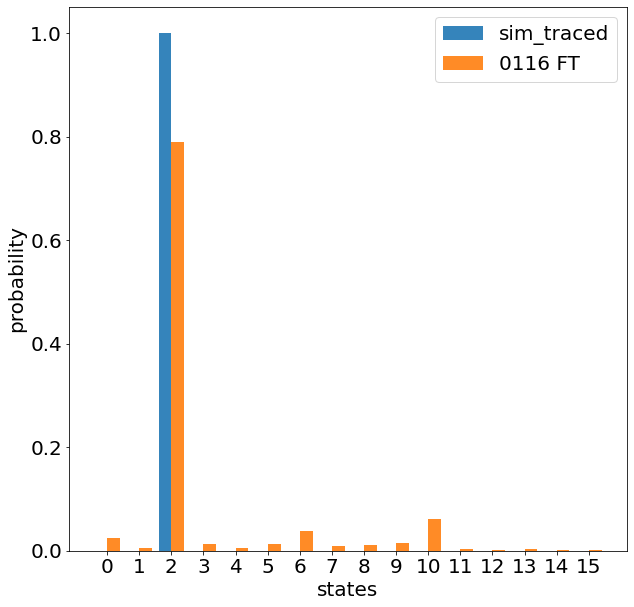

2024-01-16-153717_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



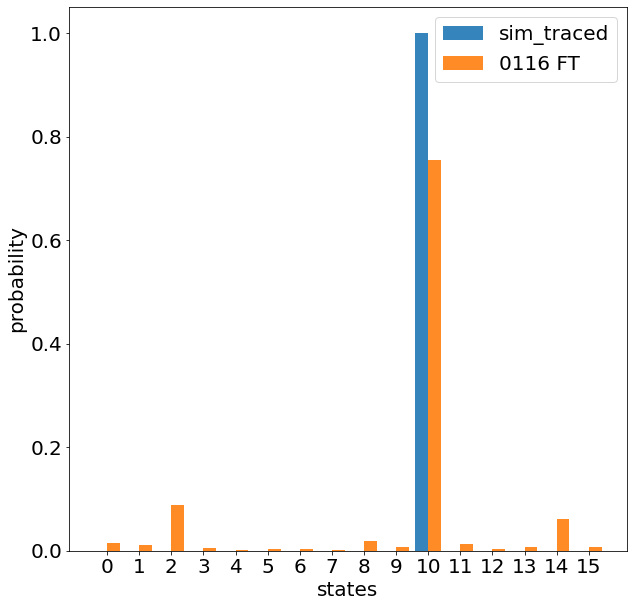

2024-01-16-153745_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



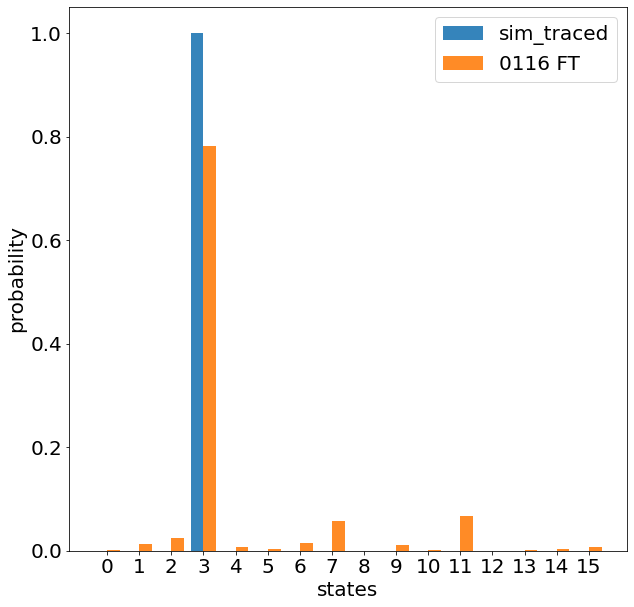

2024-01-16-153812_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



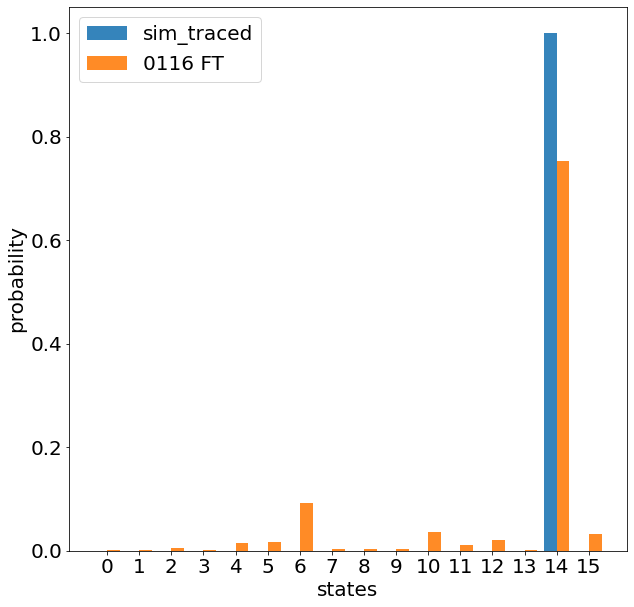

2024-01-16-153838_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



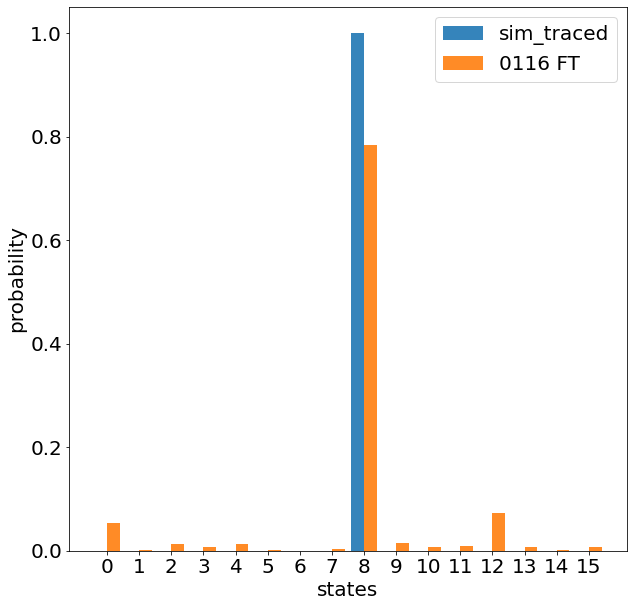

2024-01-16-154046_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



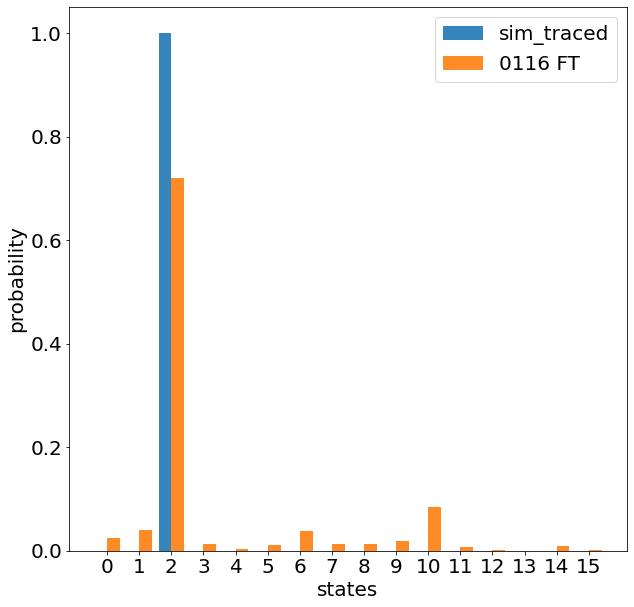

2024-01-16-154113_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



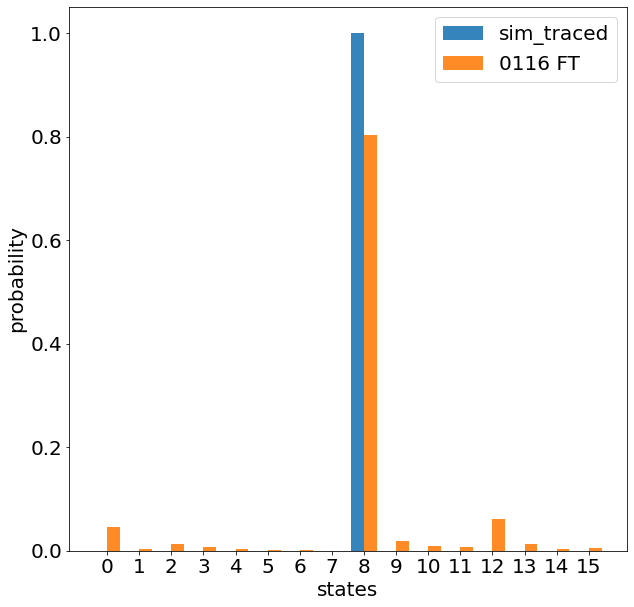

2024-01-16-154140_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



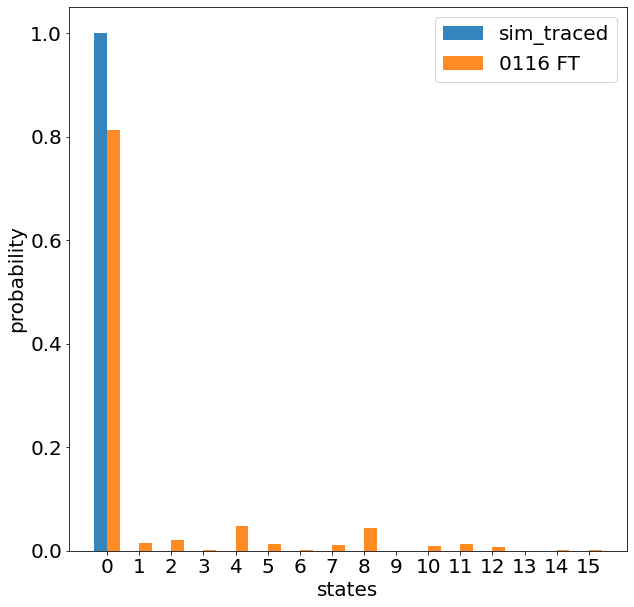

2024-01-16-154207_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



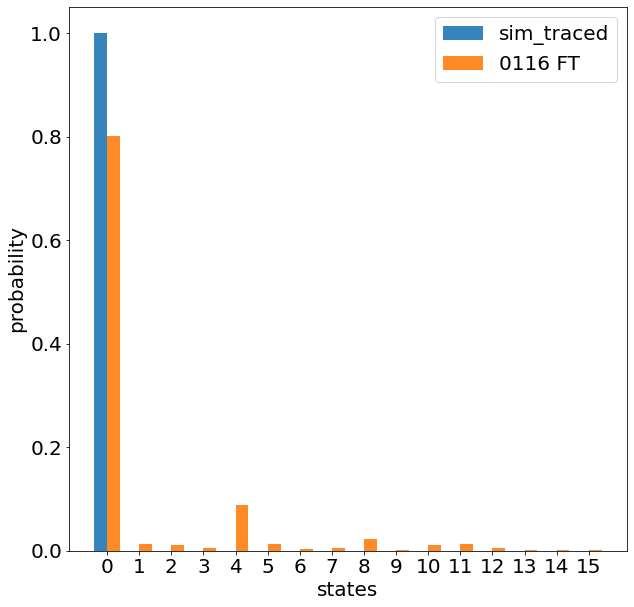

2024-01-16-154235_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



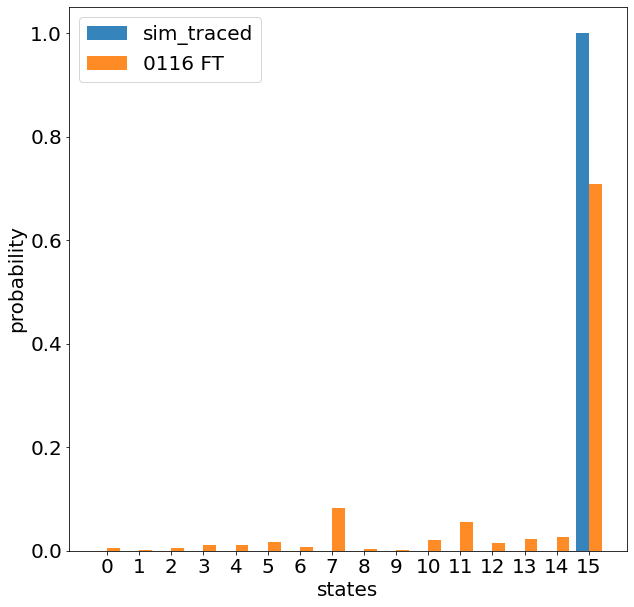

2024-01-16-201708_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



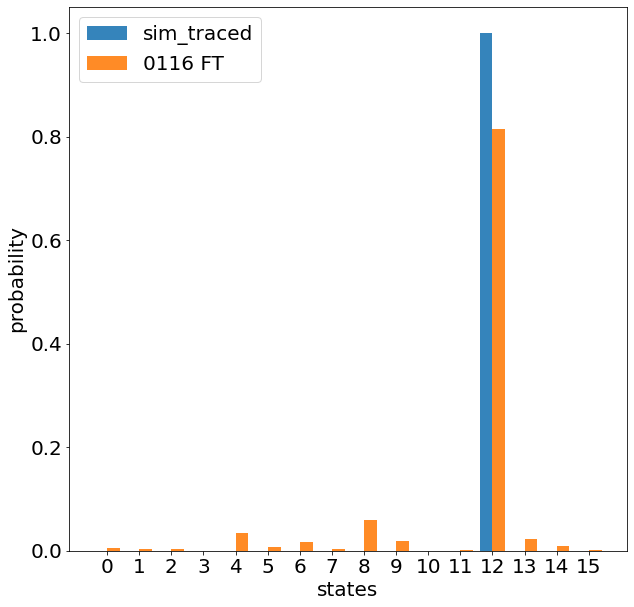

2024-01-16-201735_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



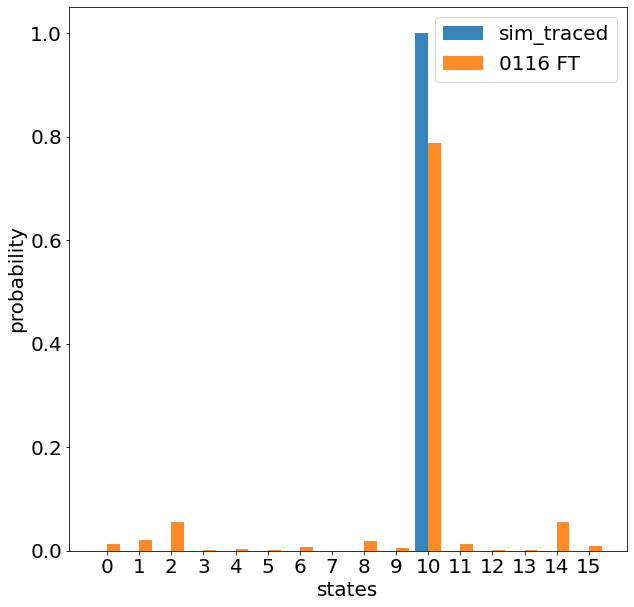

2024-01-16-201803_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



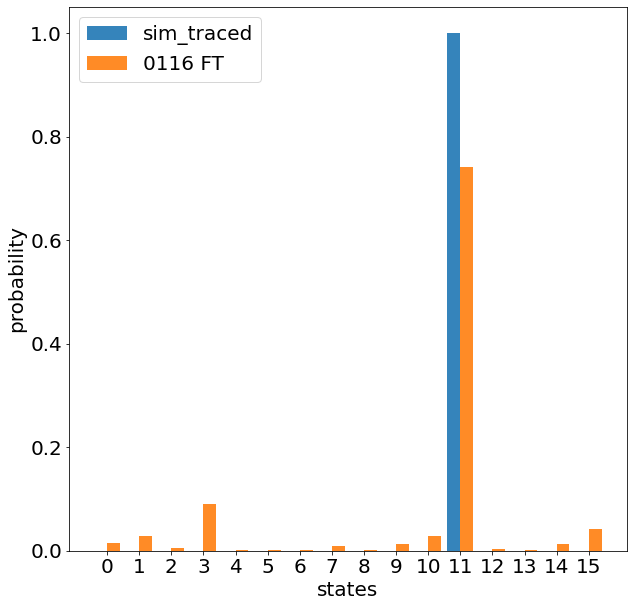

2024-01-16-201830_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



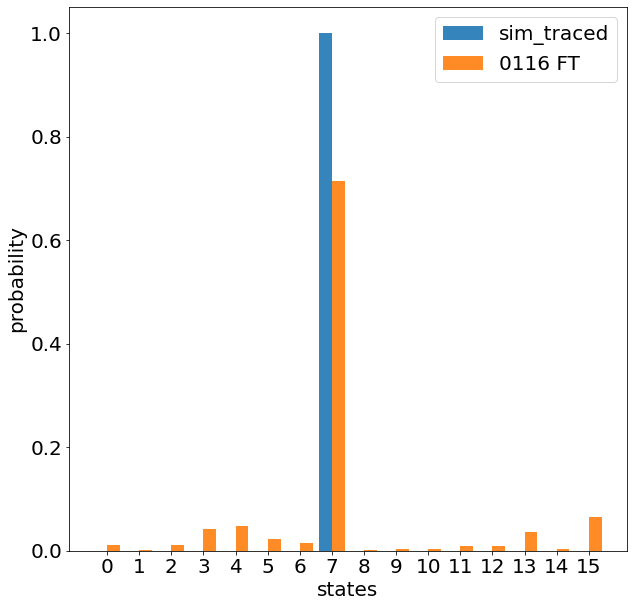

2024-01-16-201857_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



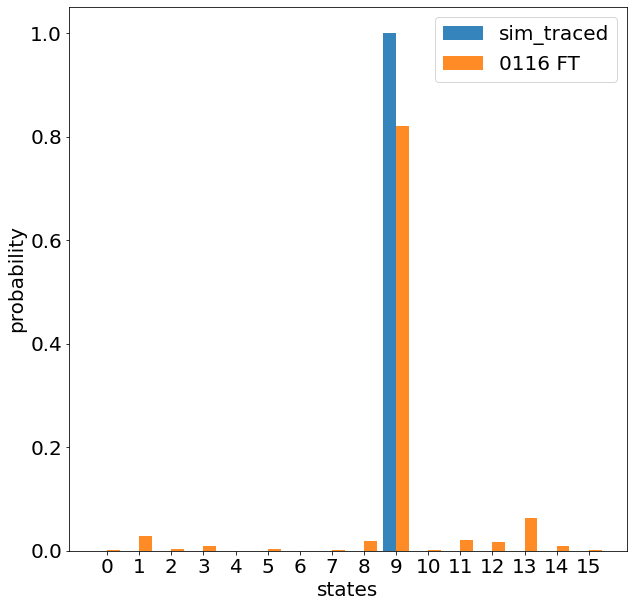

2024-01-16-202021_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



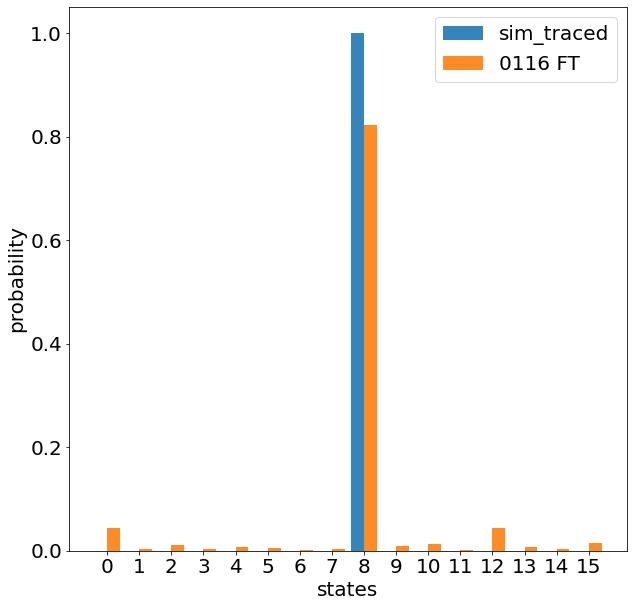

2024-01-16-202049_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



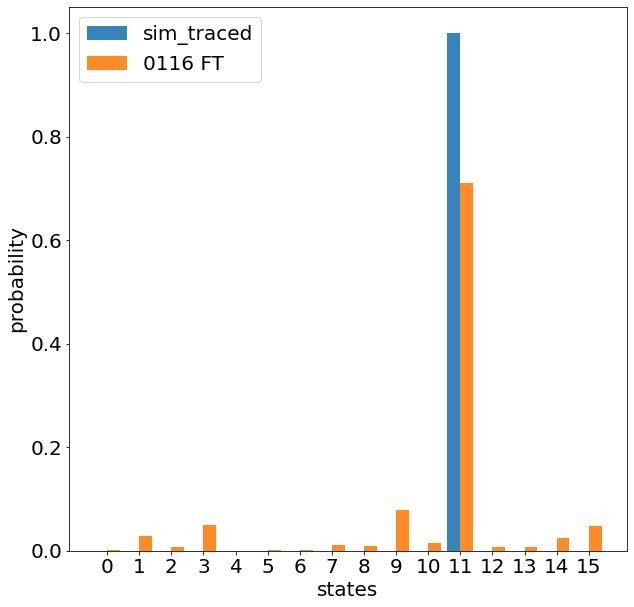

2024-01-16-202117_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



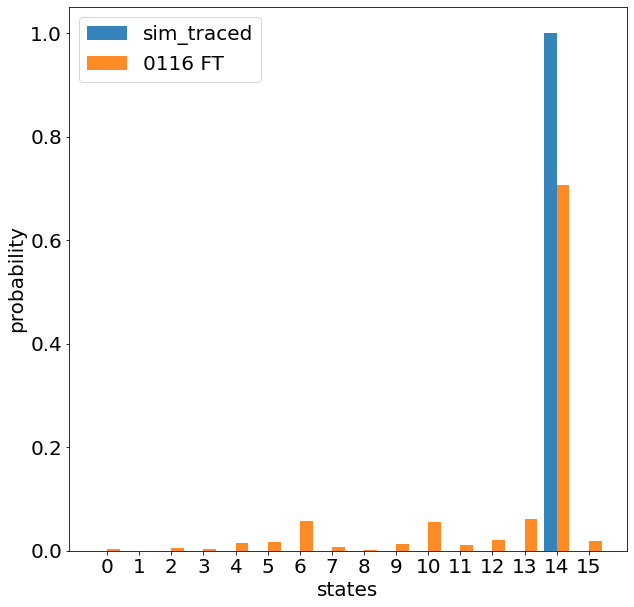

2024-01-16-202143_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



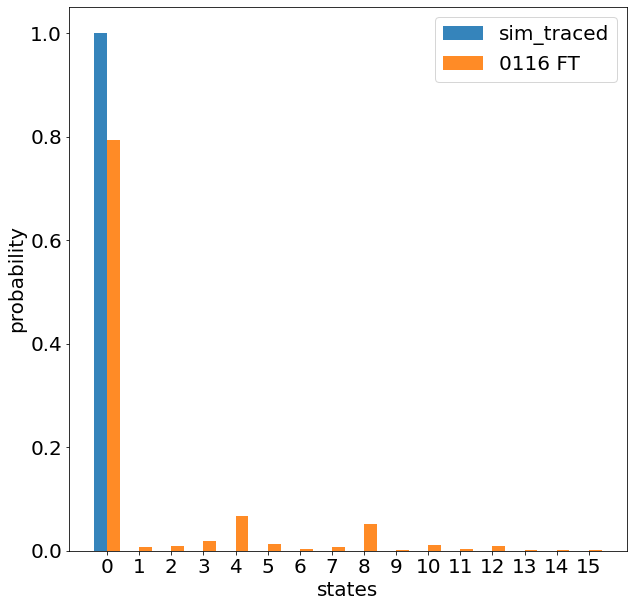

2024-01-16-202210_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



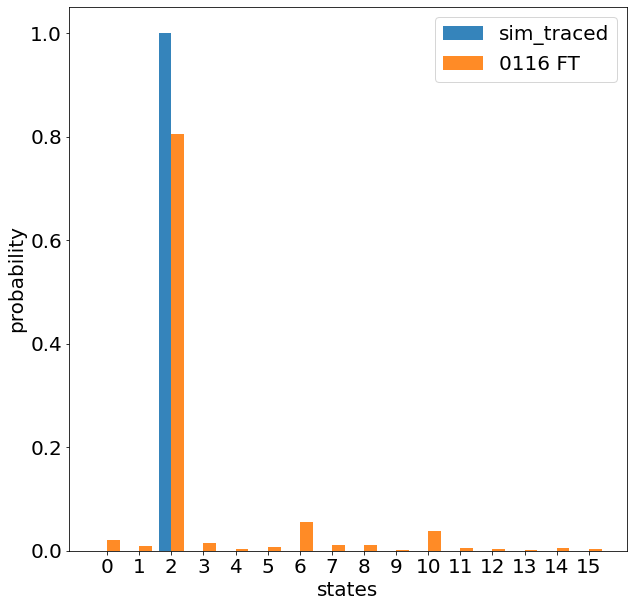

In [45]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4.copy()
print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d4
circuit=c_d4
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)
    
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d4_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d4_0703+filenames_d4_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0116 FT"])
# #         

2024-01-16-154610_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



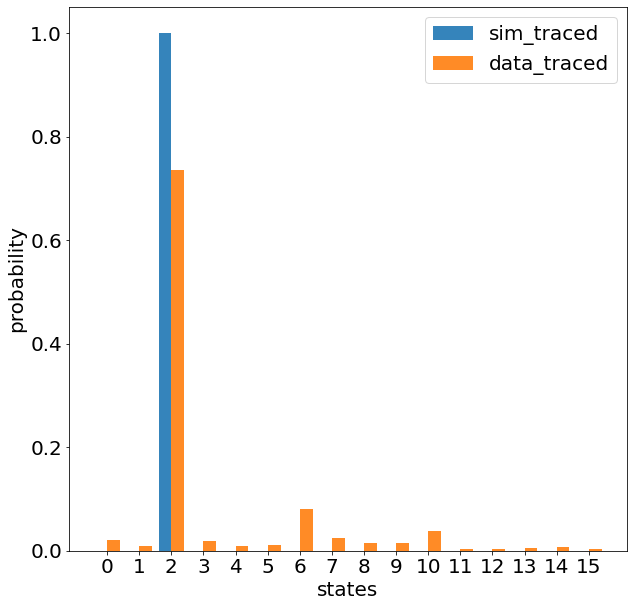

2024-01-16-154644_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



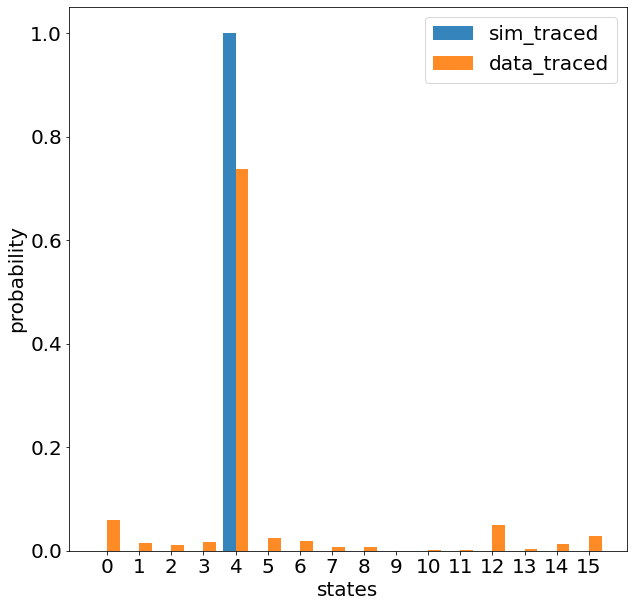

2024-01-16-154719_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



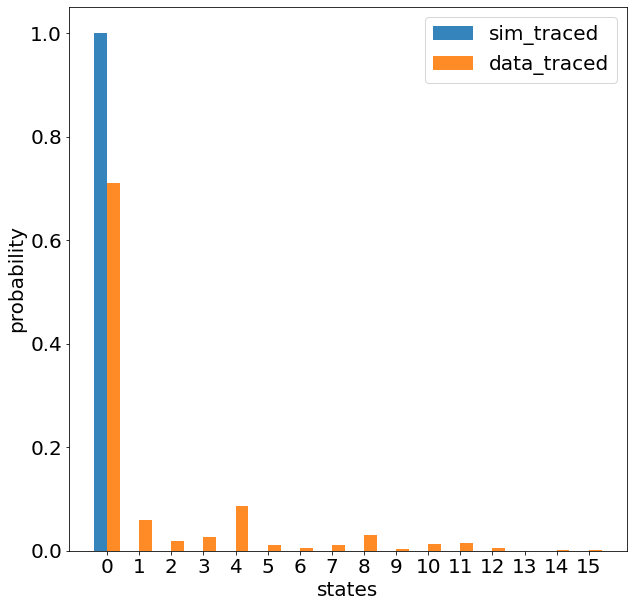

2024-01-16-154755_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



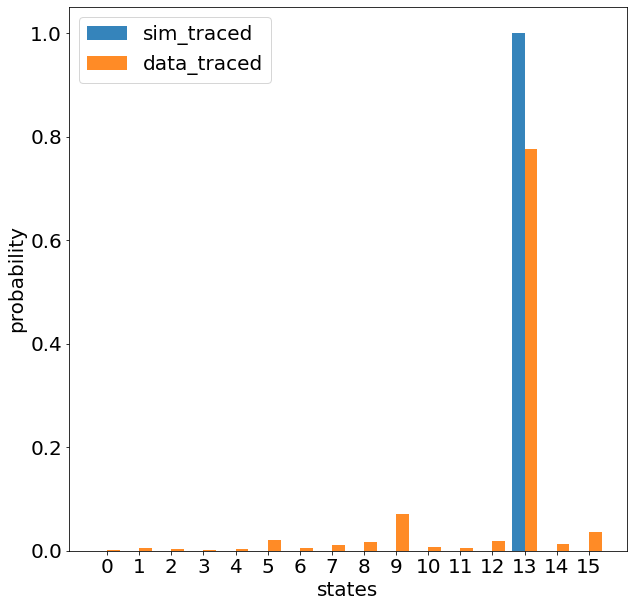

2024-01-16-154829_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



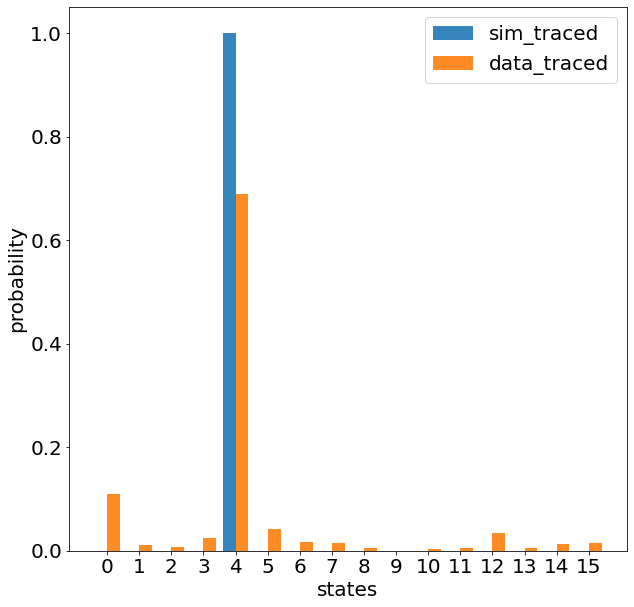

2024-01-16-162418_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



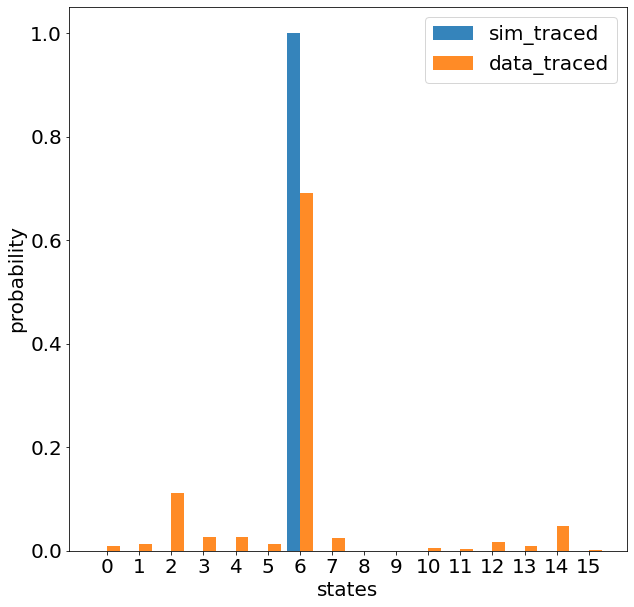

2024-01-16-162453_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



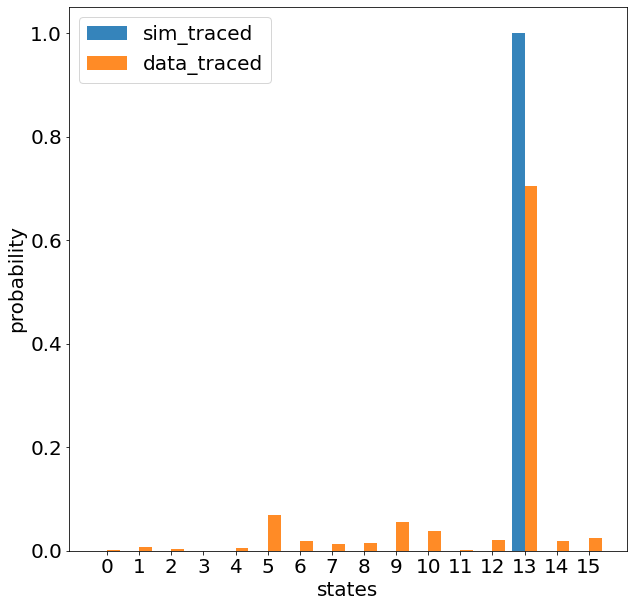

2024-01-16-162529_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



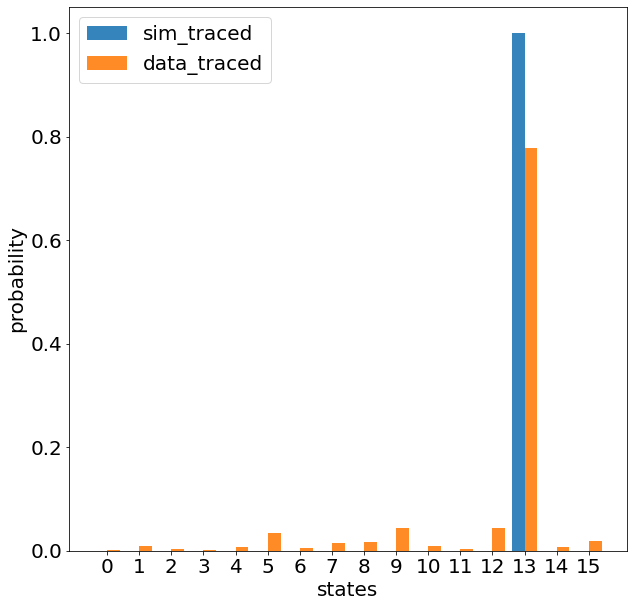

2024-01-16-163626_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



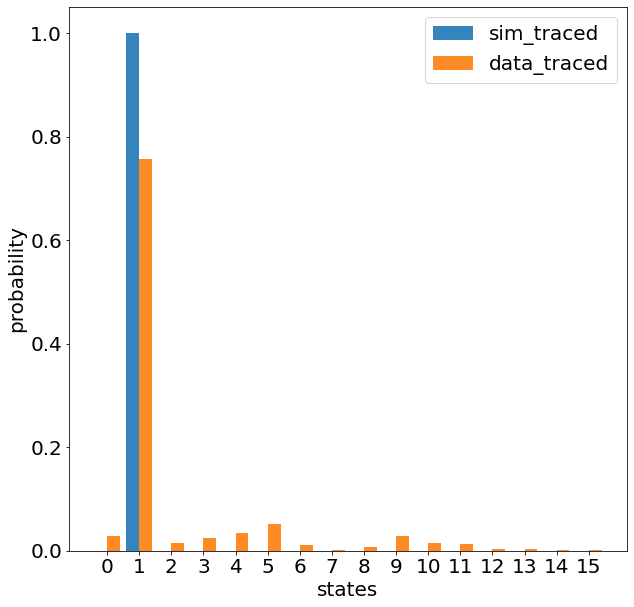

2024-01-16-163702_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



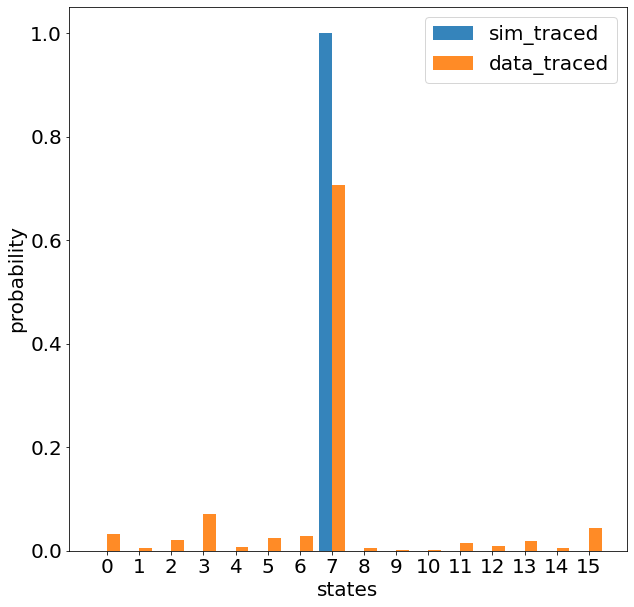

2024-01-16-200056_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



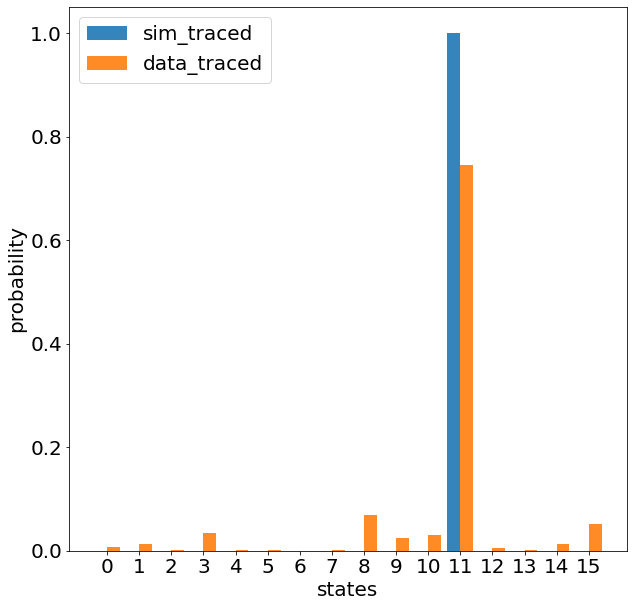

2024-01-16-200131_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



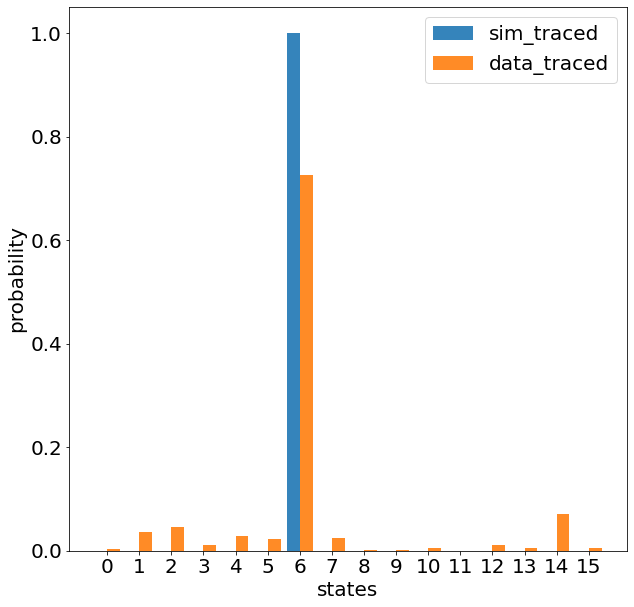

2024-01-16-200206_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



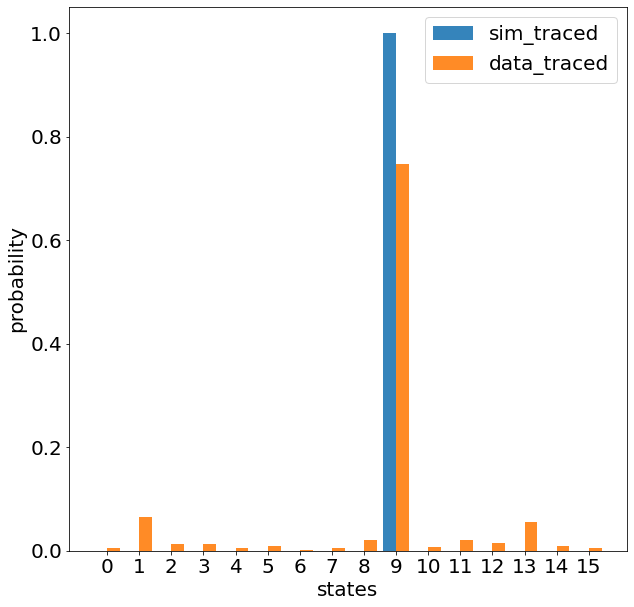

2024-01-16-200241_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



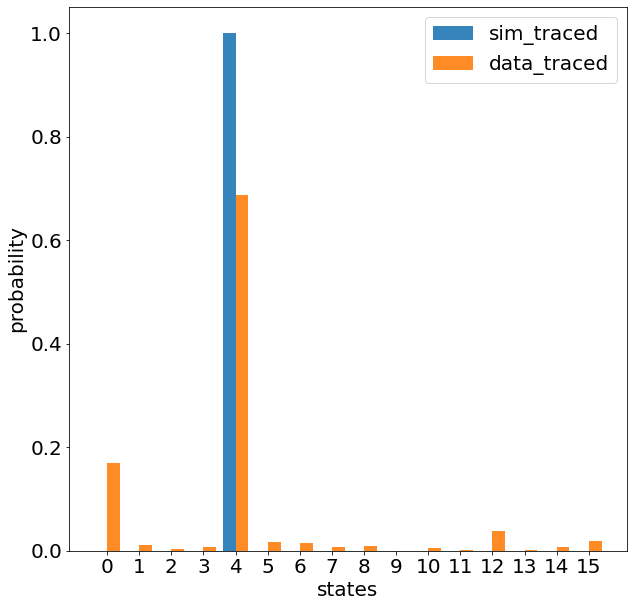

2024-01-16-200316_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



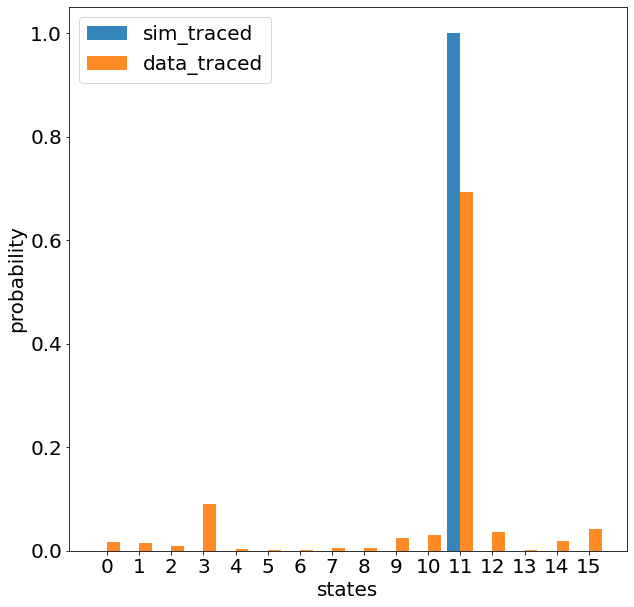

2024-01-16-200448_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



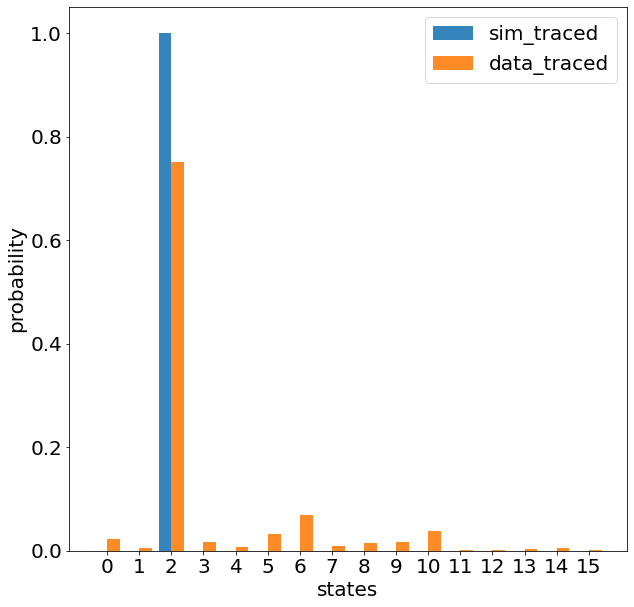

2024-01-16-200523_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



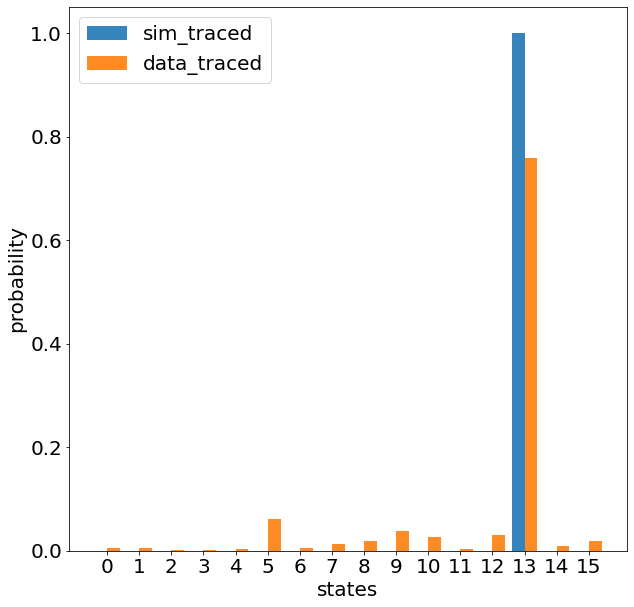

2024-01-16-200559_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



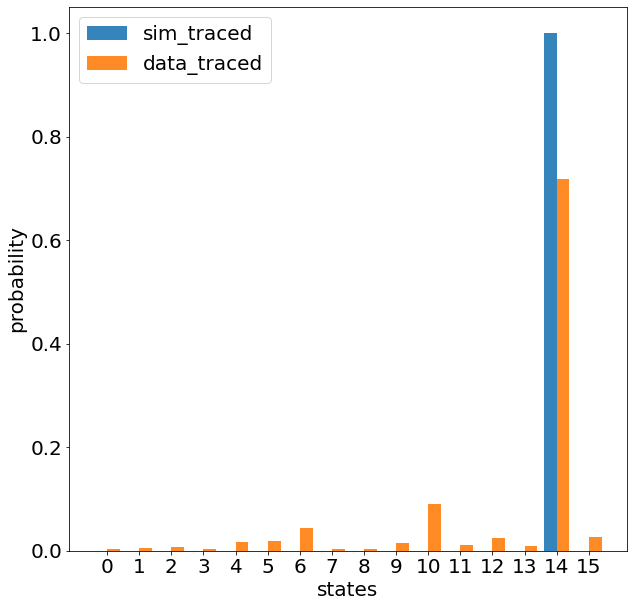

2024-01-16-200634_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



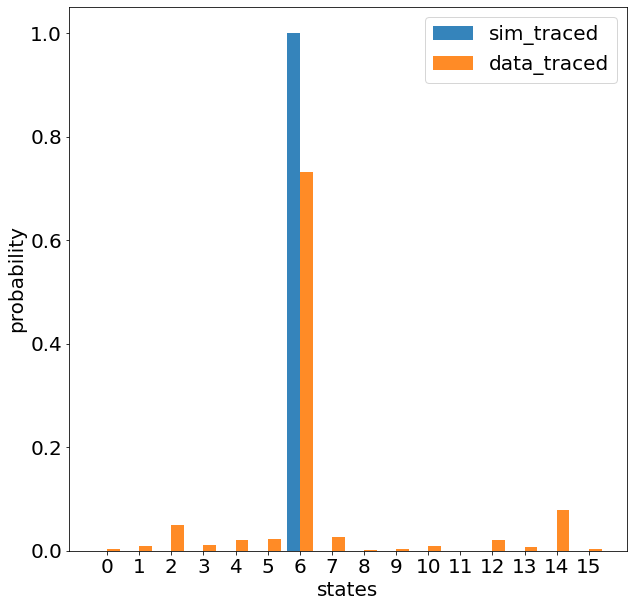

2024-01-16-201422_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



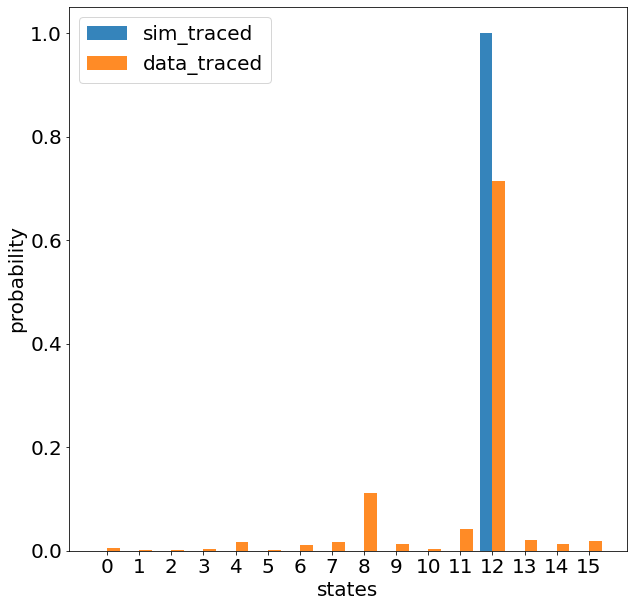

In [46]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

2024-01-16-170126_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



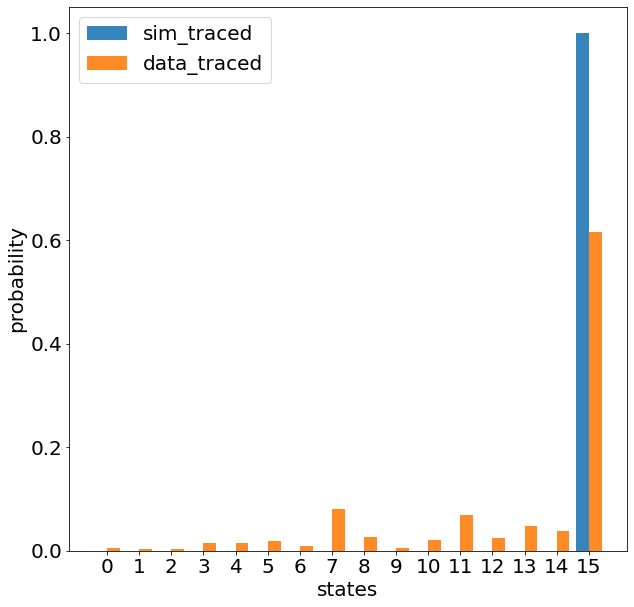

2024-01-16-170220_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



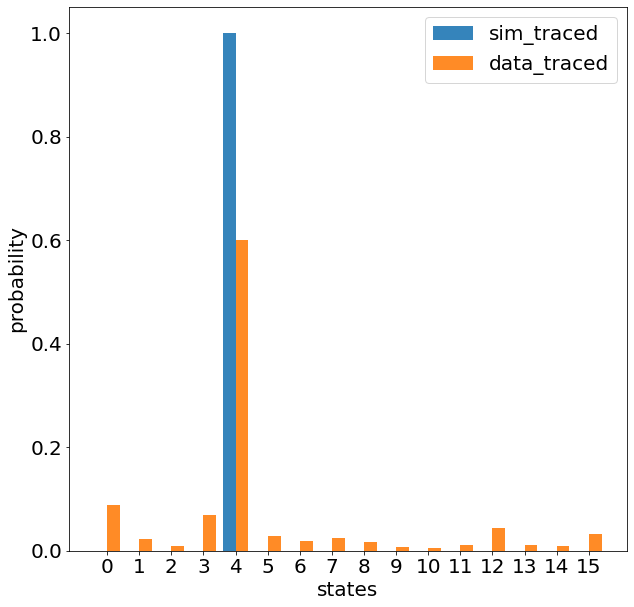

2024-01-16-170314_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



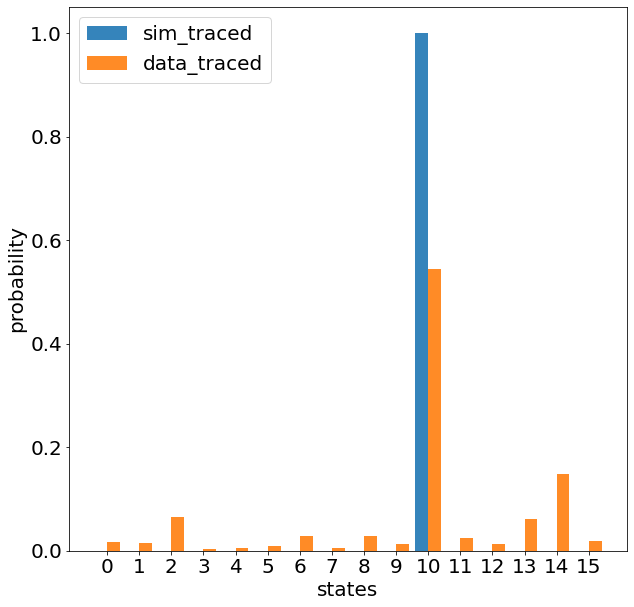

2024-01-16-170410_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



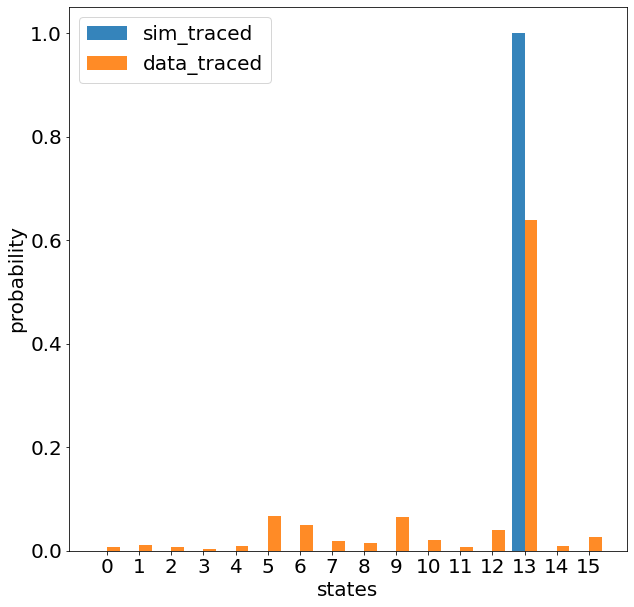

2024-01-16-170601_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



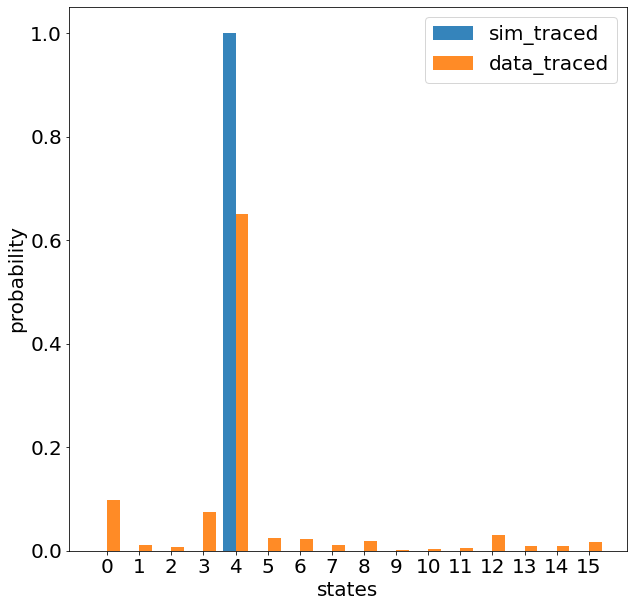

2024-01-16-170656_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



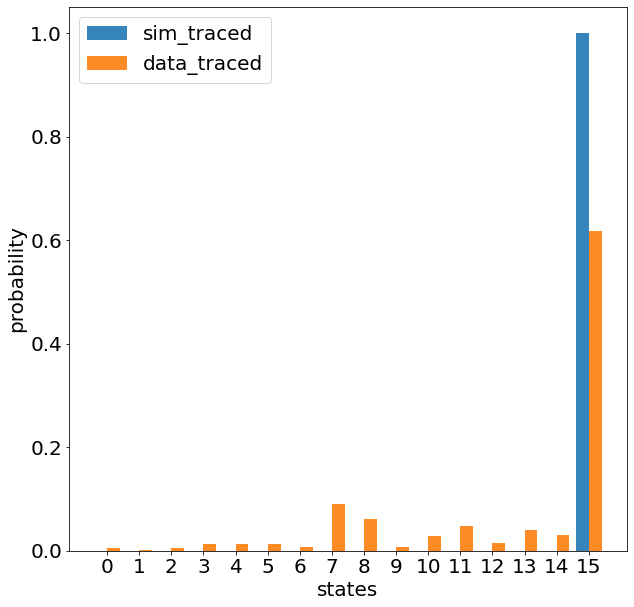

2024-01-16-170750_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



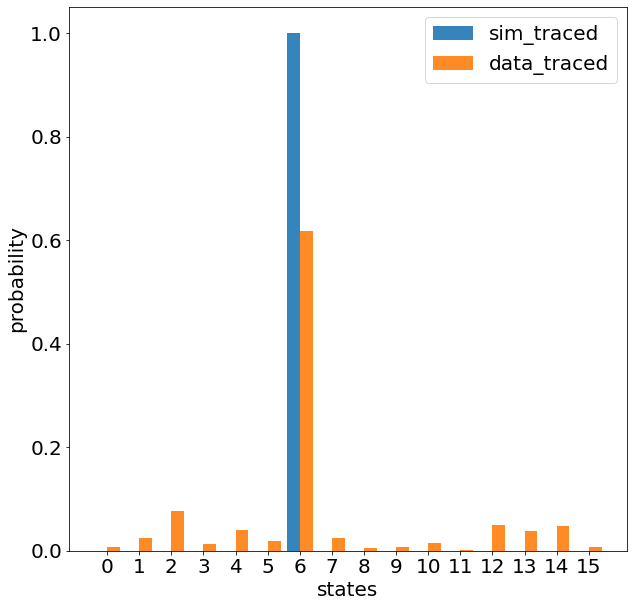

2024-01-16-170844_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



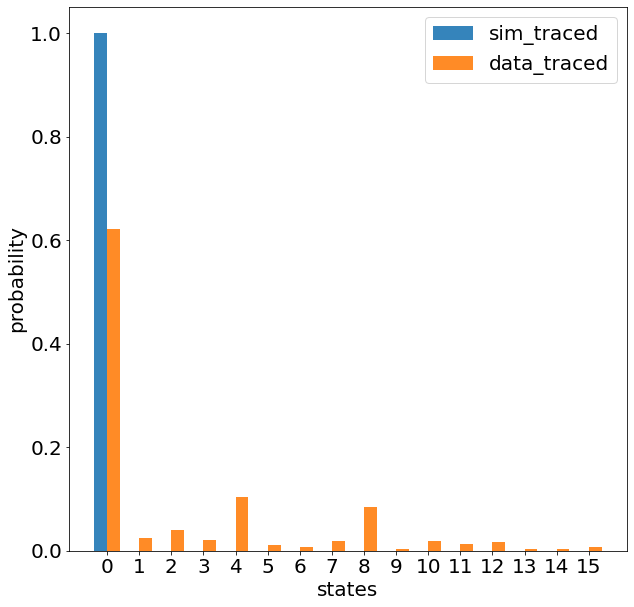

2024-01-16-171035_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



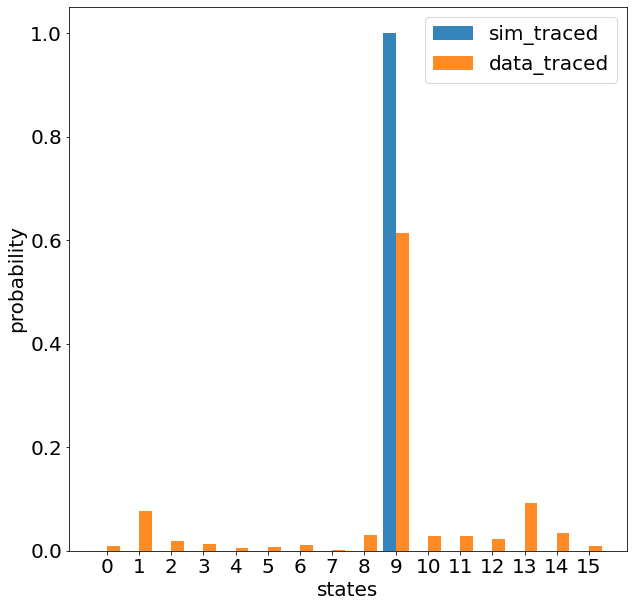

2024-01-16-171129_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



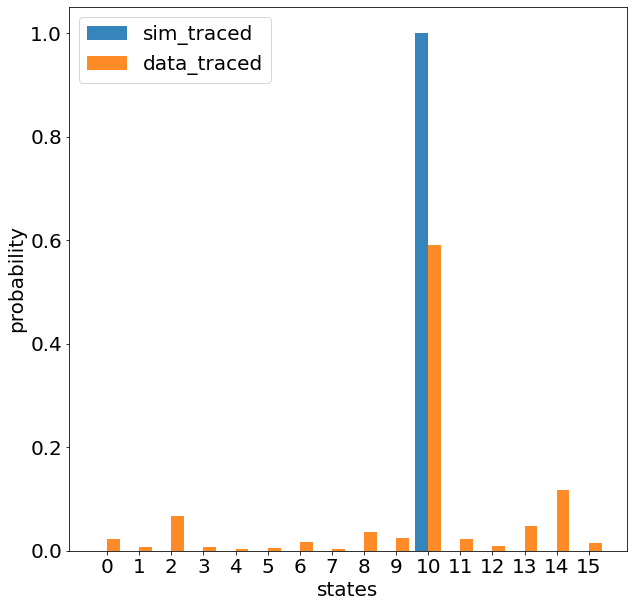

2024-01-16-171225_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



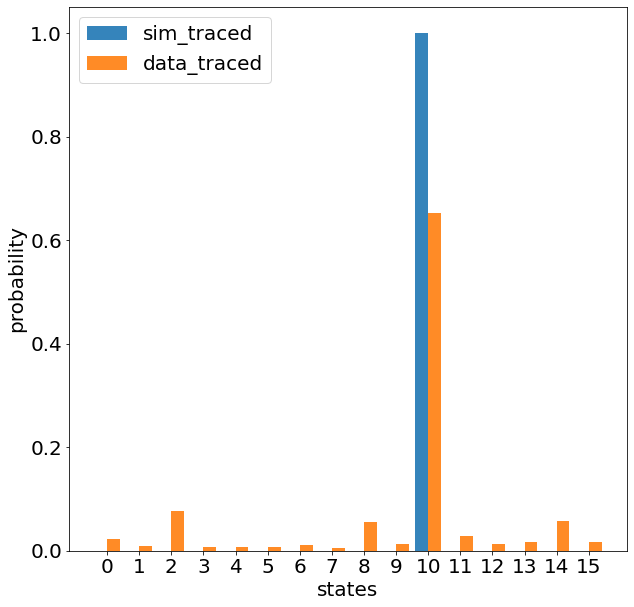

2024-01-16-194936_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



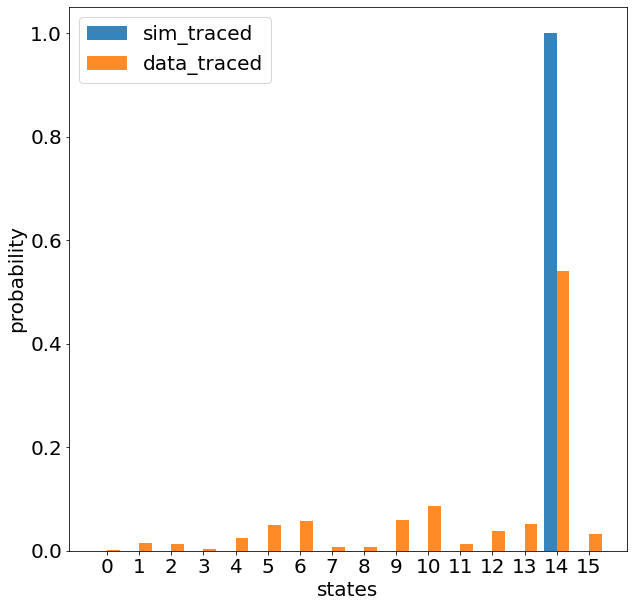

2024-01-16-195028_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



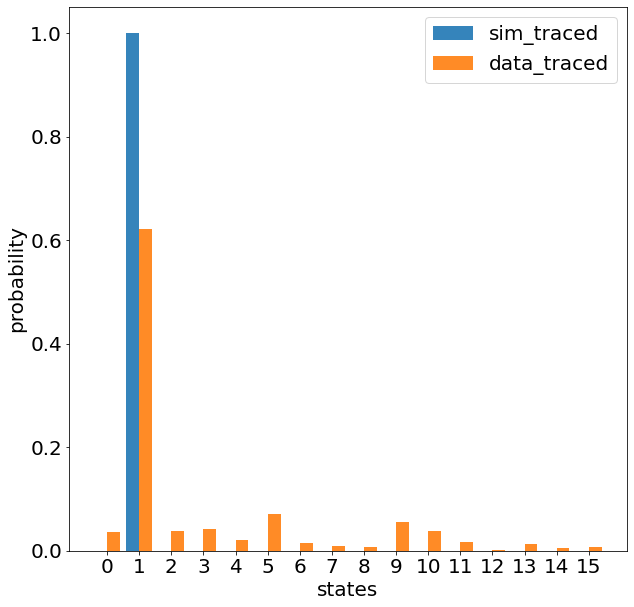

2024-01-16-195121_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



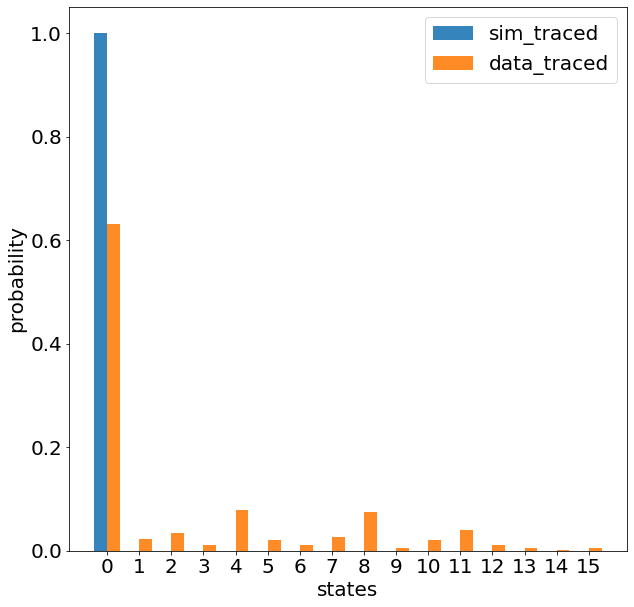

2024-01-16-195213_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



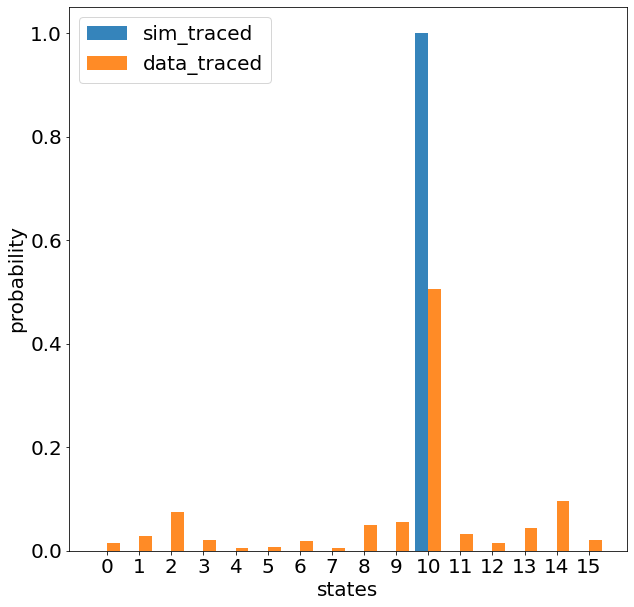

2024-01-16-195404_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



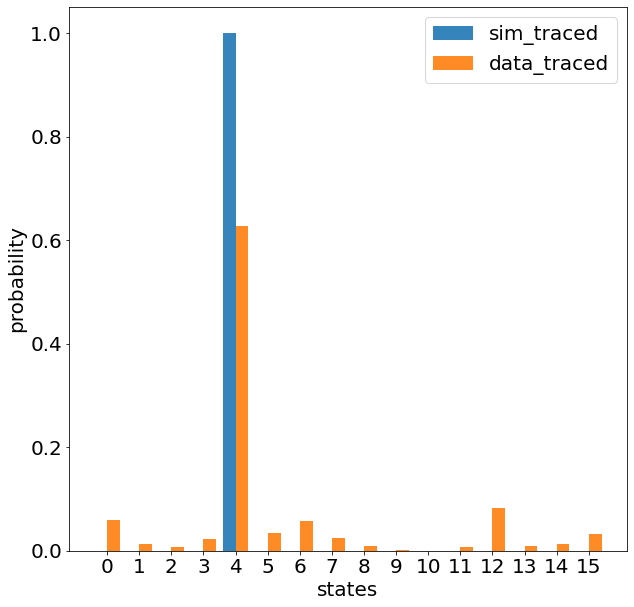

2024-01-16-195456_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



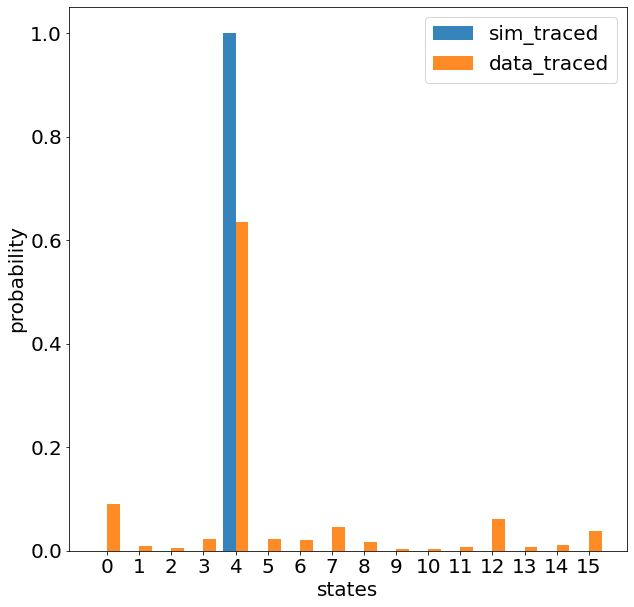

2024-01-16-195549_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



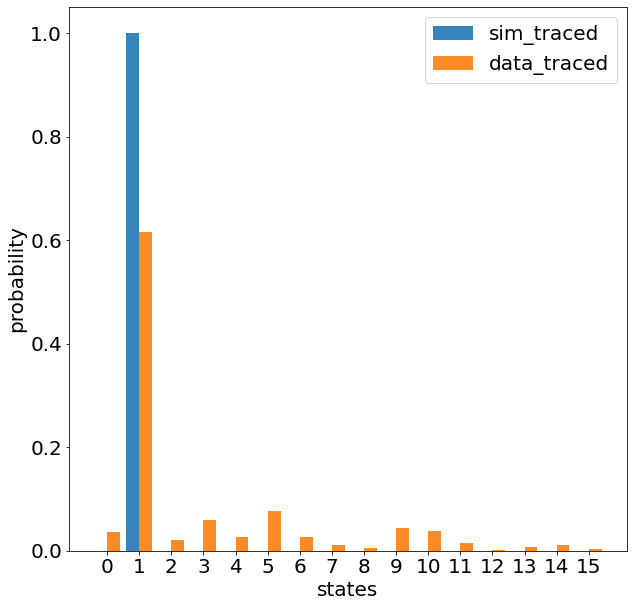

2024-01-16-195643_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



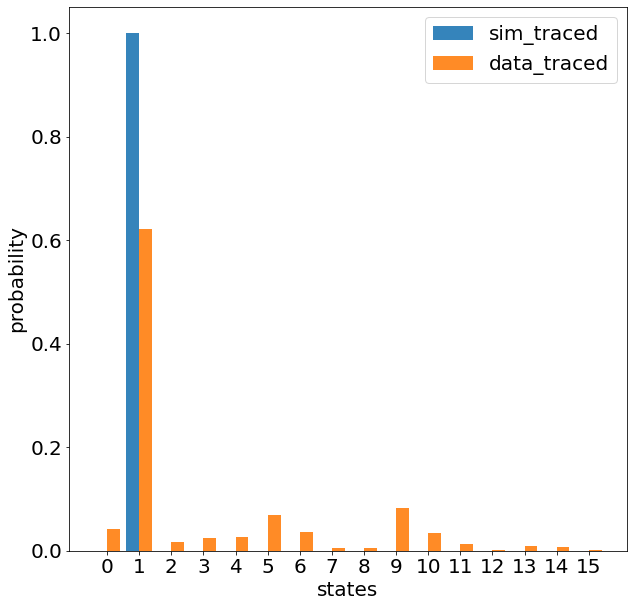

2024-01-16-195833_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



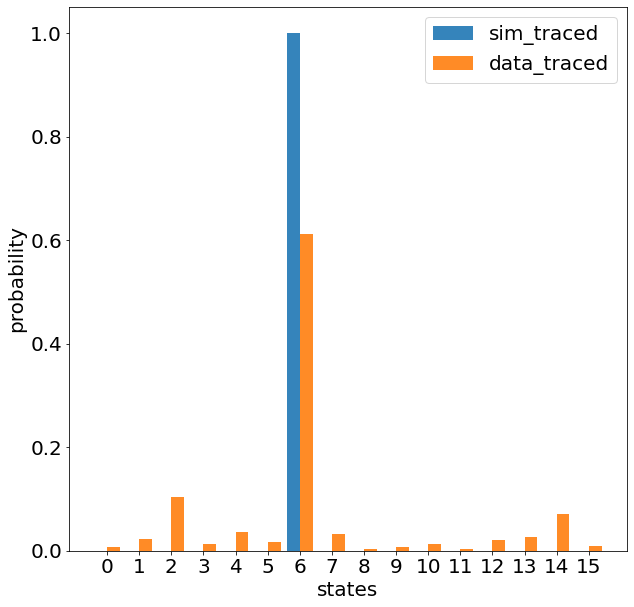

In [47]:
filenames_data=[]
counts_d16=[]
counts_d16_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d16.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d16
circuit=c_d16
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d16.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

2024-01-16-171544_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:

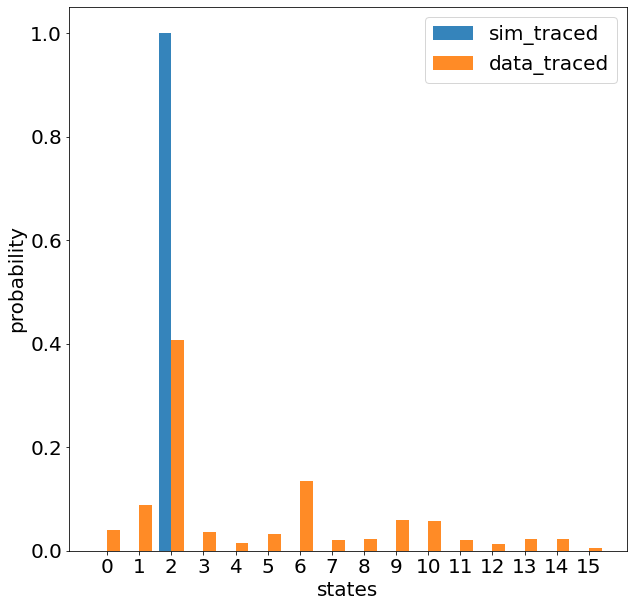

2024-01-16-171720_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3


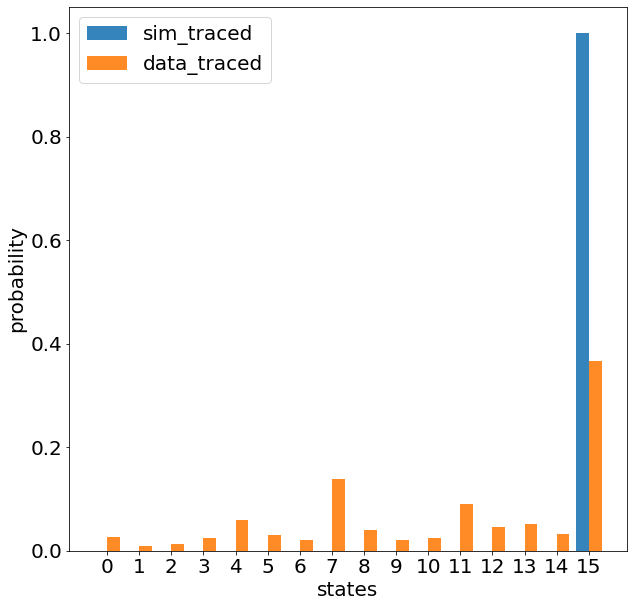

2024-01-16-171858_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



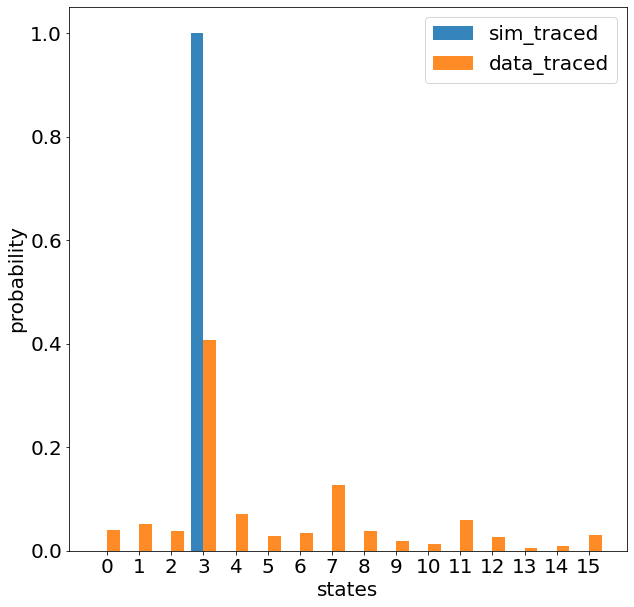

2024-01-16-172134_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:A

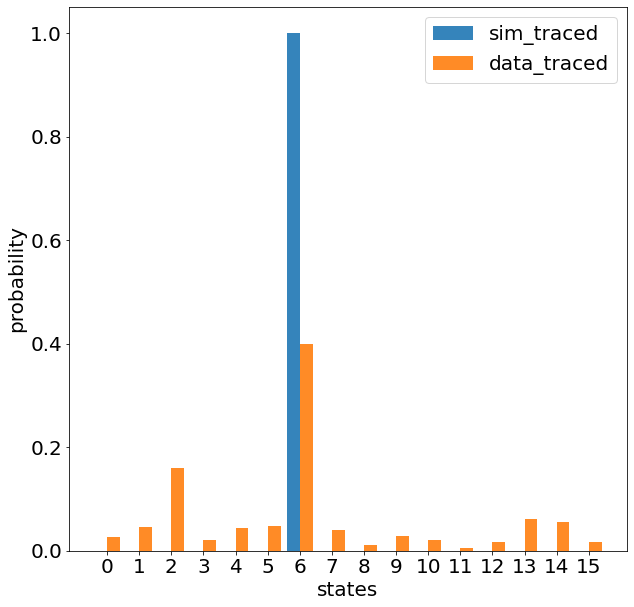

2024-01-16-172312_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



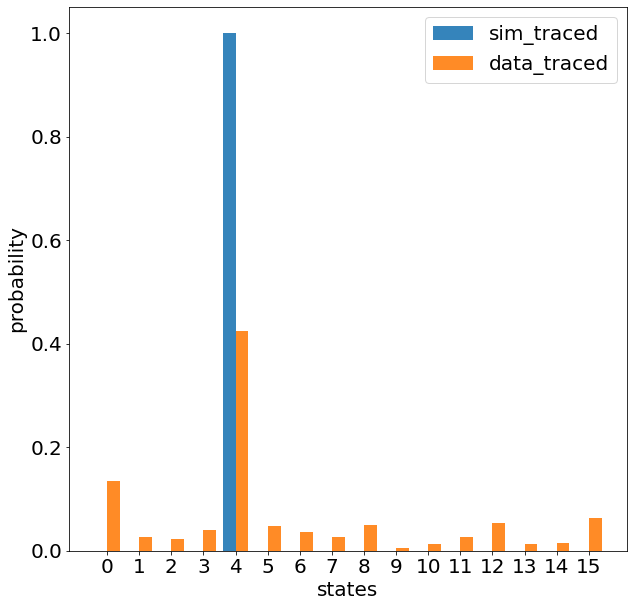

2024-01-16-172452_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:R

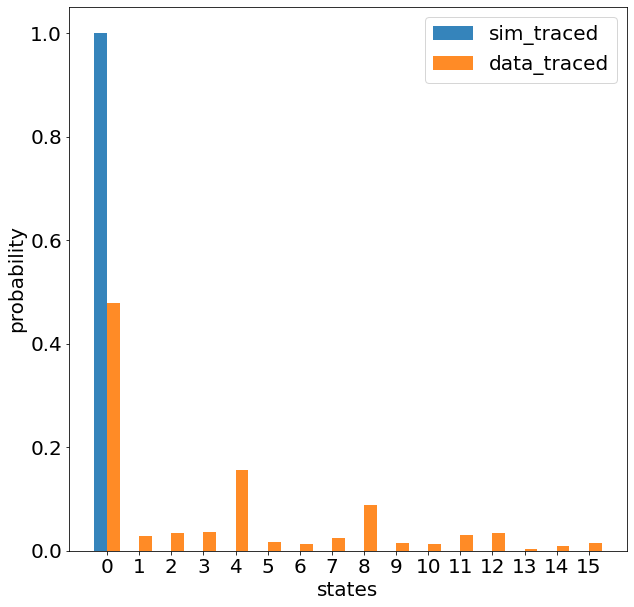

2024-01-16-174237_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



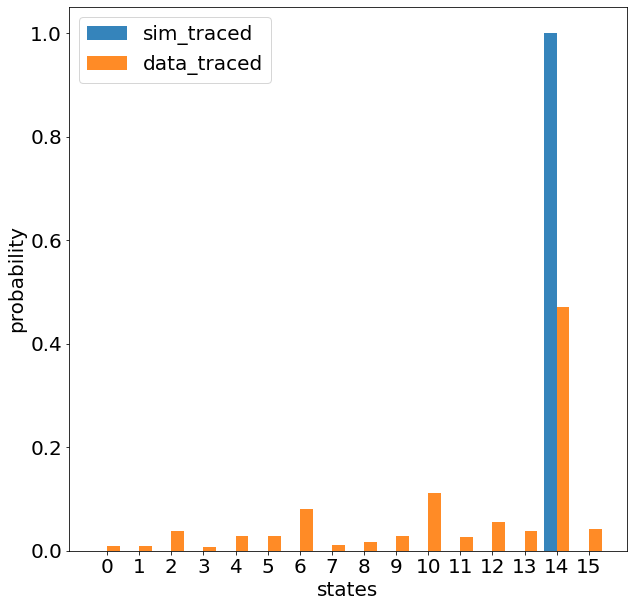

2024-01-16-174415_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32

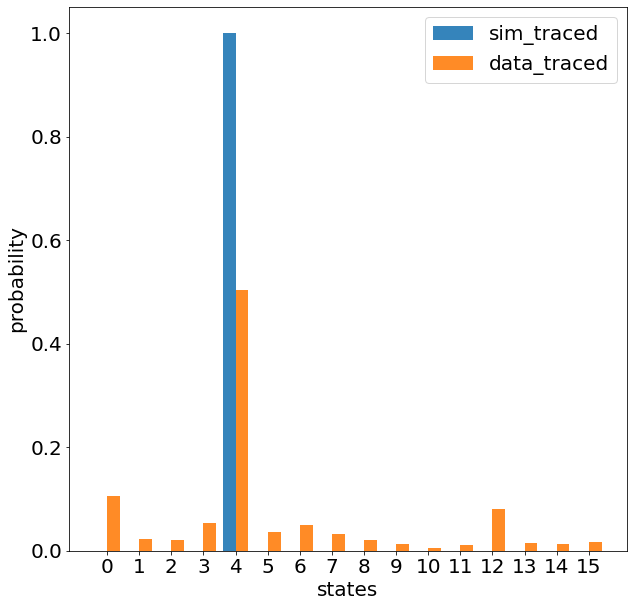

2024-01-16-174650_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



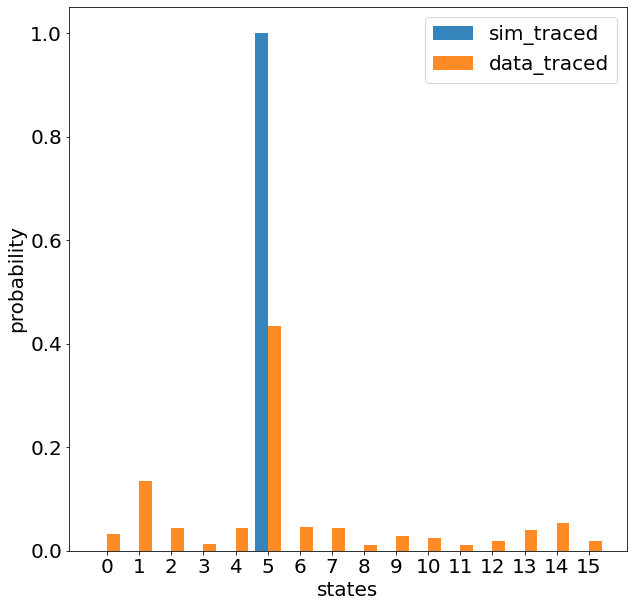

2024-01-16-174827_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



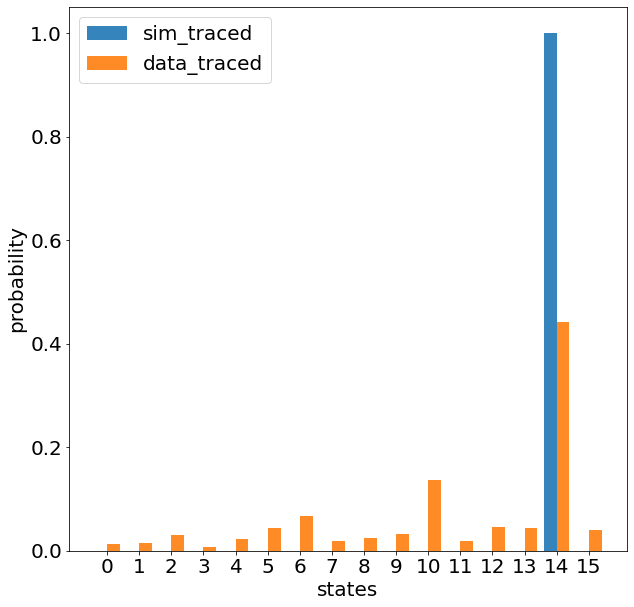

2024-01-16-191704_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



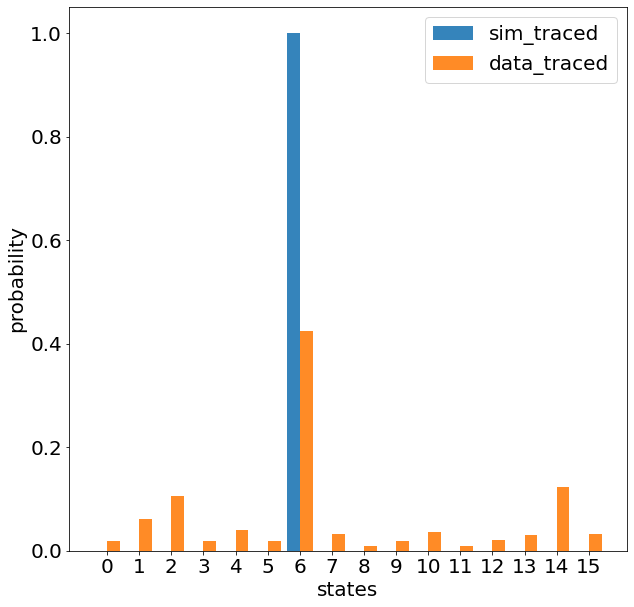

2024-01-16-191842_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD

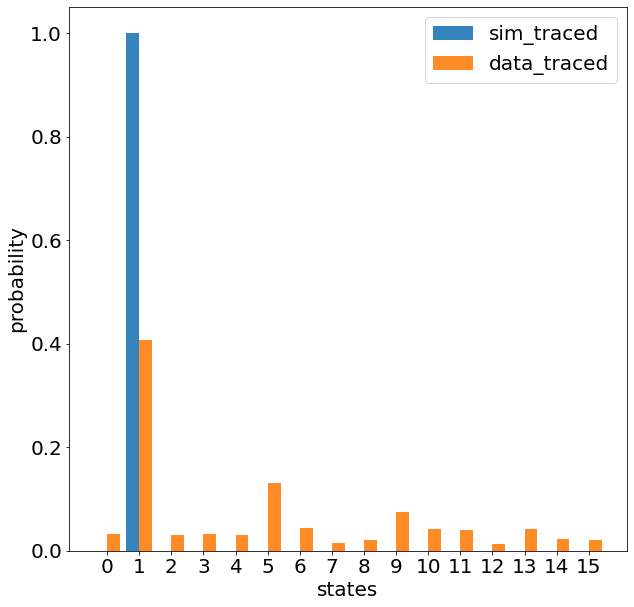

2024-01-16-192017_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



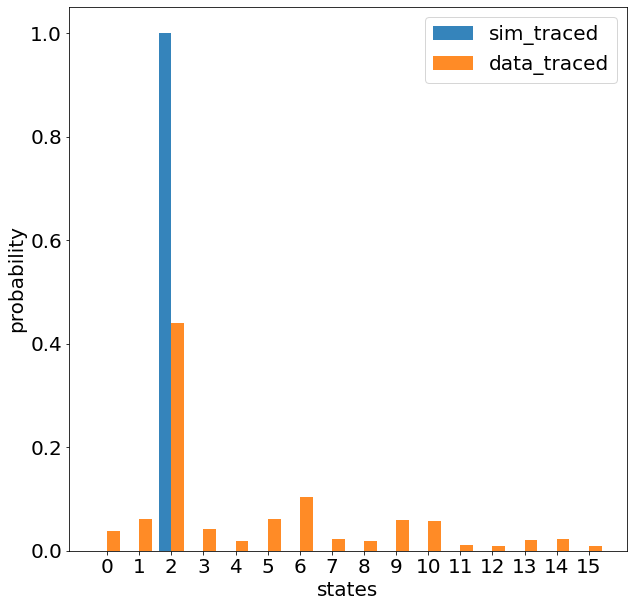

2024-01-16-192254_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:H

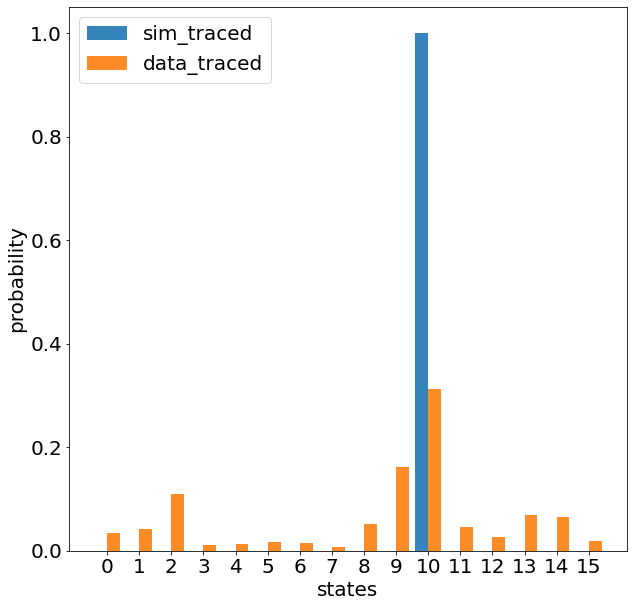

2024-01-16-193555_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD

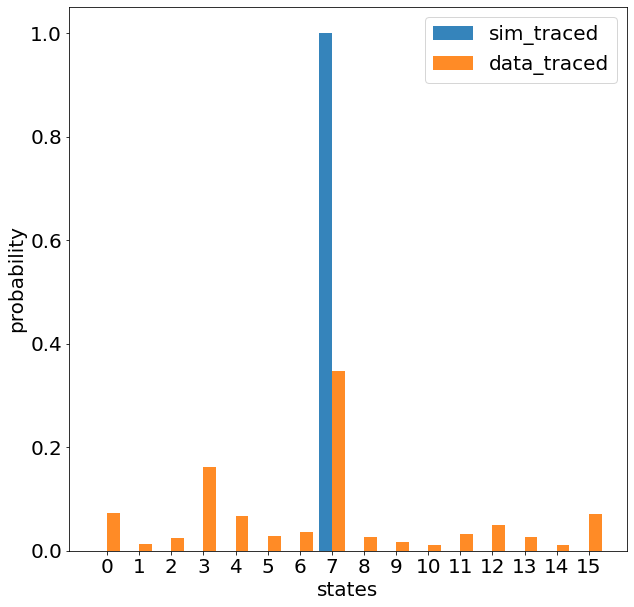

2024-01-16-193735_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



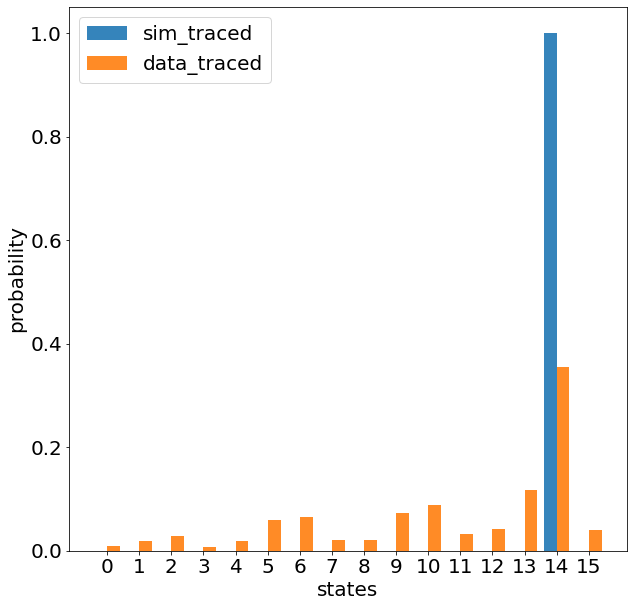

2024-01-16-193913_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



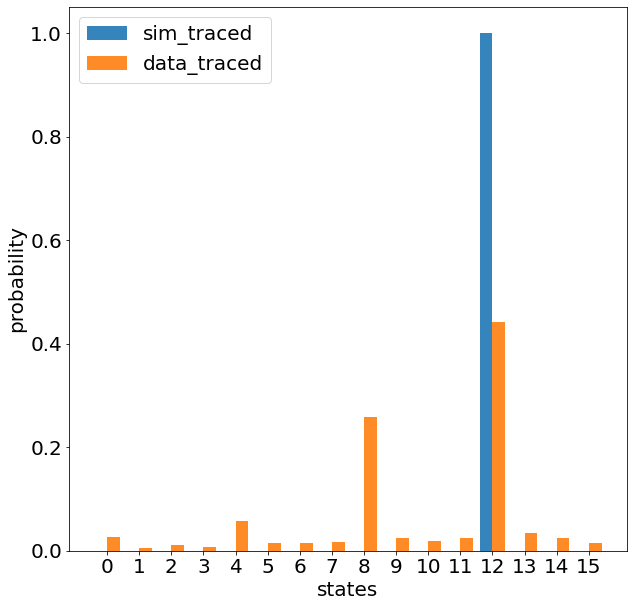

2024-01-16-194147_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:

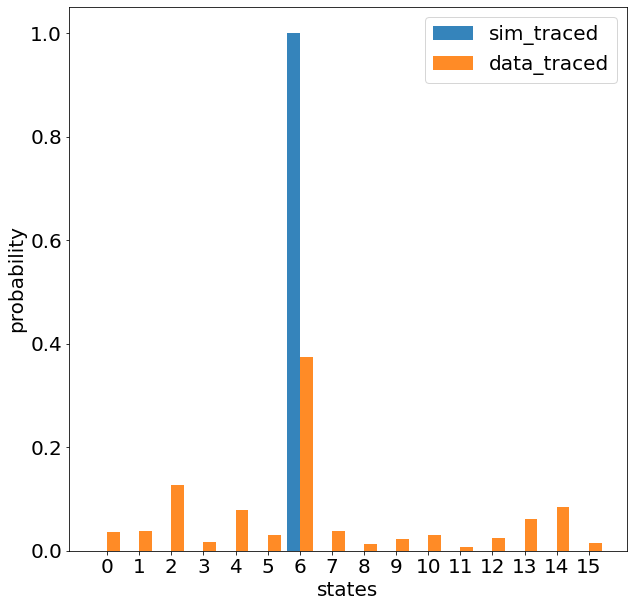

2024-01-16-194326_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



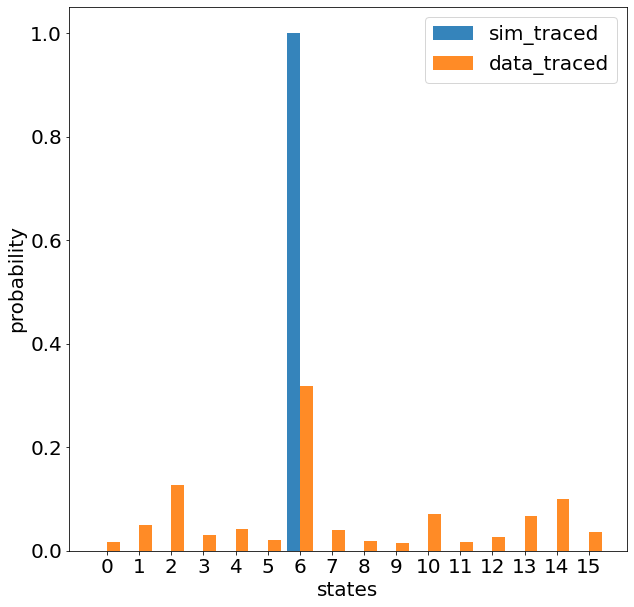

2024-01-16-194504_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



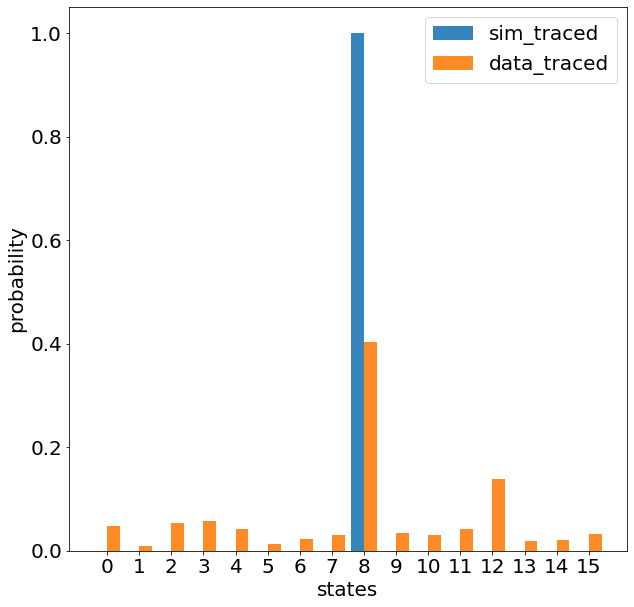

In [48]:
filenames_data=[]
counts_d32=[]
counts_d32_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d32.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d32
circuit=c_d32
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d32.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

In [44]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [29]:
import copy
from copy import copy, deepcopy
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/XX23541_noSE_explicitCNOT_FT_R0627_01+10/5842626d-f518-4838-a0a2-c93e640ed4ffXX23541_noSE_explicitCNOT_FT_R0627_01+10", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)

eab_load_cpy=deepcopy(eab_load[0:100])
eab_load_cpy_spam=deepcopy(eab_load[0:100])

In [49]:
C=20
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    print (eab_load_cpy[i]["counts"])
    print (counts_d2_sim[i])

    print (counts_d2[i].copy())
    print ("\n")
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
# for i in range (C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==2
#     eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

{'0000': 4, '1000': 39, '0100': 34, '1100': 1625, '0010': 2, '1010': 1, '0110': 34, '1110': 101, '0001': 4, '1001': 36, '0101': 5, '1101': 103, '0011': 0, '1011': 2, '0111': 3, '1111': 7}
{'0000': 0, '1000': 0, '0100': 0, '1100': 2000, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 4, '1000': 39, '0100': 34, '1100': 1625, '0010': 2, '1010': 1, '0110': 34, '1110': 101, '0001': 4, '1001': 36, '0101': 5, '1101': 103, '0011': 0, '1011': 2, '0111': 3, '1111': 7}


{'0000': 179, '1000': 22, '0100': 0, '1100': 10, '0010': 1659, '1010': 32, '0110': 12, '1110': 3, '0001': 5, '1001': 0, '0101': 3, '1101': 3, '0011': 51, '1011': 3, '0111': 13, '1111': 5}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 179, '1000': 22, '0100': 0, '1100': 10, '0010': 1659, '1010': 32,

In [50]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==4
#     eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-C].copy()

    #     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (C,2*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [51]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

# for i in range (2*C,3*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==8
#     eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-2*C].copy()

#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (2*C,3*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [52]:
# print (eab_load_cpy)

In [53]:
for i in range (3*C,4*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==16
    eab_load_cpy[i]["counts"]=counts_d16[i-3*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

for i in range (4*C,5*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==32
    eab_load_cpy[i]["counts"]=counts_d32[i-4*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

In [54]:
filename = str(uuid.uuid4())
filename+="FTXX_EAB_23541_01162024_01+10_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/results/"+filename, "wb") as fp:
    pickle.dump(eab_load_cpy, fp)


In [55]:
print (eab_load_cpy)

[{'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '+ZI'], 'destabilizer': ['+IX', '+XI']}, 'clifford_layer': 'XX', 'counts': {'0000': 4, '1000': 39, '0100': 34, '1100': 1625, '0010': 2, '1010': 1, '0110': 34, '1110': 101, '0001': 4, '1001': 36, '0101': 5, '1101': 103, '0011': 0, '1011': 2, '0111': 3, '1111': 7}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['-IZ', '-ZI'], 'destabilizer': ['+IX', '-XI']}, 'clifford_layer': 'XX', 'counts': {'0000': 179, '1000': 22, '0100': 0, '1100': 10, '0010': 1659, '1010': 32, '0110': 12, '1110': 3, '0001': 5, '1001': 0, '0101': 3, '1101': 3, '0011': 51, '1011': 3, '0111': 13, '1111': 5}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['-IZ', '-ZI'], 'destabilizer': ['+IX', '-XI']}, 'clifford_layer': 'XX', 'counts': {'0000': 247, '1000': 17, '0100': 5, '1100': 3, '0010': 1518, '1010': 33, '0110': 22, '1110': 44, '0001': 19, '1001': 3, '0101': 6, '1101': 0, '0011': 60, '1011': 1, '0111': 14, '1111': 8}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['-

Data analysis

plot average fidelity and fit

plot fidelity from each circuit and fit

data analysis with bootstrapping

spam results

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)